# Mod 5 Project - Using Machine Learning to Predict Coronavirus

This project uses daily updated coronavirus data from John Hopkins Hospital

## COVID-19 MAP

### HOW MANY COUNTRIES, HOW MANY PEOPLE CONTAGIOUS, HOW MANY DEATH CASES???

## PERCENTAGE OF CONFIRMED CASES/POPULATION, DEATH CASES/CONFIRMED CASES, RECOVERED/CONFIRMED CASES.

### STEP 1: IMPORT ALL NECCESSARY LIBRARIES

In [1]:
# import all neccessary libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import itertools

sns.set_style('whitegrid')
plt.style.use('ggplot')

# ignore all harmless waring to keep the notebook clean
warnings.filterwarnings('ignore')

# keep the plot inline in notebookb
%matplotlib inline

### STEP 2: LOAD DATA
#### We have 3 data sets: Confirmed cases, Death cases & Recovered cases

In [5]:
# load data
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
df_confirmed = pd.read_csv(url + 'time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv(url + 'time_series_covid19_deaths_global.csv')
df_recovered = pd.read_csv(url + 'time_series_covid19_recovered_global.csv')

In [6]:
df_population_K = pd.read_csv('population_by_country_2020.csv')
df_population_K.head()

Country (or dependency)  Population (2020) Yearly Change  Net Change  \
0                   China         1439323776         0.39%     5540090   
1                   India         1380004385         0.99%    13586631   
2           United States          331002651         0.59%     1937734   
3               Indonesia          273523615         1.07%     2898047   
4                Pakistan          220892340         2.00%     4327022   

   Density (P/Km²)  Land Area (Km²)  Migrants (net) Fert. Rate Med. Age  \
0              153          9388211       -348399.0        1.7       38   
1              464          2973190       -532687.0        2.2       28   
2               36          9147420        954806.0        1.8       38   
3              151          1811570        -98955.0        2.3       30   
4              287           770880       -233379.0        3.6       23   

  Urban Pop % World Share  
0         61%      18.47%  
1         35%      17.70%  
2         83%       4.25%  
3         56%       3.51%  
4         35%       2.83%

In [7]:
df_population_K.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 11 columns):
Country (or dependency)    235 non-null object
Population (2020)          235 non-null int64
Yearly Change              235 non-null object
Net Change                 235 non-null int64
Density (P/Km²)            235 non-null int64
Land Area (Km²)            235 non-null int64
Migrants (net)             201 non-null float64
Fert. Rate                 235 non-null object
Med. Age                   235 non-null object
Urban Pop %                235 non-null object
World Share                235 non-null object
dtypes: float64(1), int64(4), object(6)
memory usage: 20.3+ KB


In [8]:
df_2020_K = df_population_K.filter(['Country (or dependency)', 'Population (2020)'])
df_2020_K.reset_index(inplace=True)
df_2020_K.drop(['index'], axis=1, inplace=True)
df_2020_K.head()


Country (or dependency)  Population (2020)
0                   China         1439323776
1                   India         1380004385
2           United States          331002651
3               Indonesia          273523615
4                Pakistan          220892340

### STEP 3: INITIAL EXPLORATORY DATA ANALYSIS - EDA:

### A/ INITIAL ANALYSIS - df_confirmed

In [9]:
df_confirmed.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  3/17/20  3/18/20  3/19/20  3/20/20  \
0        0        0        0  ...       22       22       22       24   
1        0        0        0  ...       55       59       64       70   
2        0        0        0  ...       60       74       87       90   
3        0        0        0  ...       39       39       53       75   
4        0        0        0  ...        0        0        0        1   

   3/21/20  3/22/20  3/23/20  3/24/20  3/25/20  3/26/20  
0       24       40       40       74       84       94  
1       76       89      104      123      146      174  
2      139      201      230      264      302      367  
3       88      113      133      164      188      224  
4        2        2        3        3        3        4  

[5 rows x 69 columns]

In [10]:
df_confirmed.tail()

Province/State         Country/Region        Lat        Long  \
243                    NaN                   Mali  17.570692   -3.996166   
244                    NaN  Saint Kitts and Nevis  17.357822  -62.782998   
245  Northwest Territories                 Canada  64.825500 -124.845700   
246                  Yukon                 Canada  64.282300 -135.000000   
247                    NaN                 Kosovo  42.602636   20.902977   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  3/17/20  \
243        0        0        0        0        0        0  ...        0   
244        0        0        0        0        0        0  ...        0   
245        0        0        0        0        0        0  ...        0   
246        0        0        0        0        0        0  ...        0   
247        0        0        0        0        0        0  ...        0   

     3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  3/23/20  3/24/20  3/25/20  \
243        0        0        0        0        0        0        0        2   
244        0        0        0        0        0        0        0        2   
245        0        0        0        0        0        0        0        0   
246        0        0        0        0        0        0        0        0   
247        0        0        0        0        0        0        0        0   

     3/26/20  
243        4  
244        2  
245        1  
246        3  
247       71  

[5 rows x 69 columns]

In [11]:
df_confirmed.describe(include=['object', 'bool'])

Province/State Country/Region
count              76            248
unique             76            175
top             Henan          China
freq                1             33

In [9]:
df_confirmed.describe()

Lat        Long     1/22/20     1/23/20     1/24/20     1/25/20  \
count  501.000000  501.000000  501.000000  501.000000  501.000000  501.000000   
mean    30.285772  -33.097762    1.107784    1.303393    1.878244    2.862275   
std     19.870544   80.661210   19.886889   19.969170   24.875593   34.637942   
min    -41.454500 -157.858400    0.000000    0.000000    0.000000    0.000000   
25%     23.341700  -90.230800    0.000000    0.000000    0.000000    0.000000   
50%     37.251900  -73.182200    0.000000    0.000000    0.000000    0.000000   
75%     42.165700   21.824300    0.000000    0.000000    0.000000    0.000000   
max     72.000000  178.065000  444.000000  444.000000  549.000000  761.000000   

           1/26/20      1/27/20      1/28/20      1/29/20  ...       3/14/20  \
count   501.000000   501.000000   501.000000   501.000000  ...    501.000000   
mean      4.227545     5.842315    11.133733    12.307385  ...    311.564870   
std      48.422475    65.253024   159.914427   160.961540  ...   3263.324717   
min       0.000000     0.000000     0.000000     0.000000  ...      0.000000   
25%       0.000000     0.000000     0.000000     0.000000  ...      0.000000   
50%       0.000000     0.000000     0.000000     0.000000  ...      0.000000   
75%       0.000000     0.000000     0.000000     0.000000  ...     22.000000   
max    1058.000000  1423.000000  3554.000000  3554.000000  ...  67790.000000   

            3/15/20       3/16/20       3/17/20       3/18/20       3/19/20  \
count    501.000000    501.000000    501.000000    501.000000    501.000000   
mean     334.223553    362.329341    393.497006    428.962076    484.447106   
std     3332.995975   3415.516311   3511.636870   3642.374951   3832.930820   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      1.000000      1.000000      1.000000      2.000000   
75%       28.000000     37.000000     50.000000     58.000000     76.000000   
max    67794.000000  67798.000000  67799.000000  67800.000000  67800.000000   

            3/20/20       3/21/20       3/22/20       3/23/20  
count    501.000000    501.000000    501.000000    309.000000  
mean     543.245509    607.832335    670.568862   1087.391586  
std     4064.084657   4337.179809   4594.278660   5814.685942  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000     10.000000  
50%        2.000000      3.000000      3.000000     76.000000  
75%       89.000000    117.000000    135.000000    326.000000  
max    67800.000000  67800.000000  67800.000000  67800.000000  

[8 rows x 64 columns]

In [12]:
# count the null columns
null_columns = df_confirmed.columns[df_confirmed.isnull().any()]
df_confirmed[null_columns].isnull().sum().head()

Province/State    172
dtype: int64

In [13]:
# glance look at the null data
pd.set_option('display.max_columns', 999)
print(df_confirmed[df_confirmed.isnull().any(axis=1)][null_columns].head())

  Province/State
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN


In [14]:
# glance look at the null data
pd.set_option('display.max_rows', 999)
print(df_confirmed[df_confirmed.isnull().any(axis=1)][null_columns])

    Province/State
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7              NaN
16             NaN
17             NaN
18             NaN
19             NaN
20             NaN
21             NaN
22             NaN
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
30             NaN
31             NaN
32             NaN
33             NaN
34             NaN
46             NaN
47             NaN
48             NaN
82             NaN
83             NaN
84             NaN
85             NaN
86             NaN
87             NaN
88             NaN
89             NaN
90             NaN
91             NaN
94             NaN
95             NaN
96             NaN
97             NaN
98             NaN
99             NaN
100            NaN
101            NaN
102            NaN
103            NaN
104            NaN
105         

In [15]:
len(df_confirmed['Province/State'].unique())

77

In [16]:
print(df_confirmed['Province/State'].unique())

[nan 'Australian Capital Territory' 'New South Wales' 'Northern Territory'
 'Queensland' 'South Australia' 'Tasmania' 'Victoria' 'Western Australia'
 'Alberta' 'British Columbia' 'Grand Princess' 'Manitoba' 'New Brunswick'
 'Newfoundland and Labrador' 'Nova Scotia' 'Ontario'
 'Prince Edward Island' 'Quebec' 'Saskatchewan' 'Anhui' 'Beijing'
 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi' 'Guizhou' 'Hainan'
 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei' 'Hunan'
 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau' 'Ningxia'
 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan' 'Tianjin'
 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang' 'Faroe Islands' 'Greenland'
 'French Guiana' 'French Polynesia' 'Guadeloupe' 'Mayotte' 'New Caledonia'
 'Reunion' 'Saint Barthelemy' 'St Martin' 'Martinique' 'Aruba' 'Curacao'
 'Sint Maarten' 'Bermuda' 'Cayman Islands' 'Channel Islands' 'Gibraltar'
 'Isle of Man' 'Montserrat' 'Diamond Princess' 'Recovered'
 'Northwest Territories' 'Yukon'

In [17]:
len(df_confirmed['Country/Region'].unique())

175

In [16]:
print(df_confirmed['Country/Region'].unique())

['Thailand' 'Japan' 'Singapore' 'Nepal' 'Malaysia' 'Canada' 'Australia'
 'Cambodia' 'Sri Lanka' 'Germany' 'Finland' 'United Arab Emirates'
 'Philippines' 'India' 'Italy' 'Sweden' 'Spain' 'Belgium' 'Egypt'
 'Lebanon' 'Iraq' 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait' 'Algeria'
 'Croatia' 'Switzerland' 'Austria' 'Israel' 'Pakistan' 'Brazil' 'Georgia'
 'Greece' 'North Macedonia' 'Norway' 'Romania' 'Estonia' 'San Marino'
 'Belarus' 'Iceland' 'Lithuania' 'Mexico' 'New Zealand' 'Nigeria'
 'Ireland' 'Luxembourg' 'Monaco' 'Qatar' 'Ecuador' 'Azerbaijan' 'Armenia'
 'Dominican Republic' 'Indonesia' 'Portugal' 'Andorra' 'Latvia' 'Morocco'
 'Saudi Arabia' 'Senegal' 'Argentina' 'Chile' 'Jordan' 'Ukraine' 'Hungary'
 'Liechtenstein' 'Poland' 'Tunisia' 'Bosnia and Herzegovina' 'Slovenia'
 'South Africa' 'Bhutan' 'Cameroon' 'Colombia' 'Costa Rica' 'Peru'
 'Serbia' 'Slovakia' 'Togo' 'Malta' 'Martinique' 'Bulgaria' 'Maldives'
 'Bangladesh' 'Paraguay' 'Albania' 'Cyprus' 'Brunei' 'US' 'Burkina Faso'
 'Holy See'

### B/ INITIAL ANALYSIS - df_deaths

In [18]:
df_deaths.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0        0        0        0       0       0       0       0       0       0   
1        0        0        0       0       0       0       0       0       0   
2        0        0        0       0       0       0       0       0       0   
3        0        0        0       0       0       0       0       0       0   
4        0        0        0       0       0       0       0       0       0   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0       0       0       0        0        0        0        0        0   
1       0       0       0        0        1        1        1        1   
2       0       0       0        0        0        1        2        3   
3       0       0       0        0        0        0        0        0   
4       0       0       0        0        0        0        0        0   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  \
0        0        0        0        0        0        0        0        1   
1        1        1        1        2        2        2        2        2   
2        4        4        4        7        9       11       15       17   
3        0        0        0        0        0        0        0        1   
4        0        0        0        0        0        0        0        0   

   3/23/20  3/24/20  3/25/20  3/26/20  
0        1        1        2        4  
1        4        5        5        6  
2       17       19       21       25  
3        1        1        1        3  
4        0        0        0        0

In [19]:
df_deaths.tail()

Province/State         Country/Region        Lat        Long  \
243                    NaN                   Mali  17.570692   -3.996166   
244                    NaN  Saint Kitts and Nevis  17.357822  -62.782998   
245  Northwest Territories                 Canada  64.825500 -124.845700   
246                  Yukon                 Canada  64.282300 -135.000000   
247                    NaN                 Kosovo  42.602636   20.902977   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  \
243        0        0        0        0        0        0        0        0   
244        0        0        0        0        0        0        0        0   
245        0        0        0        0        0        0        0        0   
246        0        0        0        0        0        0        0        0   
247        0        0        0        0        0        0        0        0   

     1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  \
243        0        0       0       0       0       0       0       0       0   
244        0        0       0       0       0       0       0       0       0   
245        0        0       0       0       0       0       0       0       0   
246        0        0       0       0       0       0       0       0       0   
247        0        0       0       0       0       0       0       0       0   

     2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  \
243       0       0        0        0        0        0        0        0   
244       0       0        0        0        0        0        0        0   
245       0       0        0        0        0        0        0        0   
246       0       0        0        0        0        0        0        0   
247       0       0        0        0        0        0        0        0   

     2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  \
243        0        0        0        0        0        0        0        0   
244        0        0        0        0        0        0        0        0   
245        0        0        0        0        0        0        0        0   
246        0        0        0        0        0        0        0        0   
247        0        0        0        0        0        0        0        0   

     2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  \
243        0        0        0        0        0        0       0       0   
244        0        0        0        0        0        0       0       0   
245        0        0        0        0        0        0       0       0   
246        0        0        0        0        0        0       0       0   
247        0        0        0        0        0        0       0       0   

     3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  \
243       0       0       0       0       0       0       0        0        0   
244       0       0       0       0       0       0       0        0        0   
245       0       0       0       0       0       0       0        0        0   
246       0       0       0       0       0       0       0        0        0   
247       0       0       0       0       0       0       0        0        0   

     3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  \
243        0        0        0        0        0        0        0        0   
244        0        0        0        0        0        0        0        0   
245        0        0        0        0        0        0        0        0   
246        0        0        0        0        0        0        0        0   
247        0        0        0        0        0        0        0        0   

     3/20/20  3/21/20  3/22/20  3/23/20  3/24/20  3/25/20  3/26/20  
243        0        0        0        0        0        0        0  
244        0        0        0        0        0        0        0  
245        0        0  

In [20]:
df_deaths.describe(include=['object', 'bool'])

Province/State Country/Region
count              76            248
unique             76            175
top             Henan          China
freq                1             33

In [21]:
df_deaths.describe()

Lat        Long     1/22/20     1/23/20     1/24/20     1/25/20  \
count  248.000000  248.000000  248.000000  248.000000  248.000000  248.000000   
mean    22.273867   24.150757    0.068548    0.072581    0.104839    0.169355   
std     24.606559   71.375287    1.079501    1.081110    1.526121    2.541069   
min    -41.454500 -135.000000    0.000000    0.000000    0.000000    0.000000   
25%      8.390125  -15.212825    0.000000    0.000000    0.000000    0.000000   
50%     24.487000   20.972650    0.000000    0.000000    0.000000    0.000000   
75%     41.435275   85.953175    0.000000    0.000000    0.000000    0.000000   
max     71.706900  178.065000   17.000000   17.000000   24.000000   40.000000   

          1/26/20     1/27/20     1/28/20     1/29/20     1/30/20     1/31/20  \
count  248.000000  248.000000  248.000000  248.000000  248.000000  248.000000   
mean     0.225806    0.330645    0.528226    0.536290    0.689516    0.858871   
std      3.303387    4.826918    7.937459    7.937936   10.287190   12.953680   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     52.000000   76.000000  125.000000  125.000000  162.000000  204.000000   

           2/1/20      2/2/20      2/3/20      2/4/20      2/5/20      2/6/20  \
count  248.000000  248.000000  248.000000  248.000000  248.000000  248.000000   
mean     1.044355    1.459677    1.717742    1.983871    2.274194    2.556452   
std     15.810686   22.223524   26.287283   30.414407   34.858845   39.240214   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    249.000000  350.000000  414.000000  479.000000  549.000000  618.000000   

           2/7/20      2/8/20      2/9/20     2/10/20      2/11/20  \
count  248.000000  248.000000  248.000000  248.000000   248.000000   
mean     2.899194    3.250000    3.653226    4.084677     4.487903   
std     44.382971   49.525869   55.303366   61.843122    67.811598   
min      0.000000    0.000000    0.000000    0.000000     0.000000   
25%      0.000000    0.000000    0.000000    0.000000     0.000000   
50%      0.000000    0.000000    0.000000    0.000000     0.000000   
75%      0.000000    0.000000    0.000000    0.000000     0.000000   
max    699.000000  780.000000  871.000000  974.000000  1068.000000   

           2/12/20      2/13/20      2/14/20      2/15/20      2/16/20  \
count   248.000000   248.000000   248.000000   248.000000   248.000000   
mean      4.508065     5.528226     6.141129     6.717742     7.137097   
std      67.811121    83.176214    92.510467   101.336339   107.685051   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1068.000000  1310.000000  1457.000000  1596.000000  1696.000000   

           2/17/20      2/18/20      2/19/20      2/20/20      2/21/20  \
count   248.000000   248.000000   248.000000   248.000000   248.000000   
mean      7.532258     8.092742     8.556452     9.060484     9.076613   
std     113.590566   121.972169   128.828405   136.128216   136.127375   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%     

In [22]:
# count the null columns
null_columns = df_deaths.columns[df_deaths.isnull().any()]
df_deaths[null_columns].isnull().sum().head()

Province/State    172
dtype: int64

In [23]:
# glance look at the null data
pd.set_option('display.max_columns', 999)
print(df_deaths[df_deaths.isnull().any(axis=1)][null_columns].head())

  Province/State
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN


In [24]:
# glance look at the null data
pd.set_option('display.max_rows', 999)
print(df_deaths[df_deaths.isnull().any(axis=1)][null_columns])

    Province/State
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7              NaN
16             NaN
17             NaN
18             NaN
19             NaN
20             NaN
21             NaN
22             NaN
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
30             NaN
31             NaN
32             NaN
33             NaN
34             NaN
46             NaN
47             NaN
48             NaN
82             NaN
83             NaN
84             NaN
85             NaN
86             NaN
87             NaN
88             NaN
89             NaN
90             NaN
91             NaN
94             NaN
95             NaN
96             NaN
97             NaN
98             NaN
99             NaN
100            NaN
101            NaN
102            NaN
103            NaN
104            NaN
105         

In [25]:
len(df_deaths['Province/State'].unique())

77

In [26]:
print(df_deaths['Province/State'].unique())

[nan 'Australian Capital Territory' 'New South Wales' 'Northern Territory'
 'Queensland' 'South Australia' 'Tasmania' 'Victoria' 'Western Australia'
 'Alberta' 'British Columbia' 'Grand Princess' 'Manitoba' 'New Brunswick'
 'Newfoundland and Labrador' 'Nova Scotia' 'Ontario'
 'Prince Edward Island' 'Quebec' 'Saskatchewan' 'Anhui' 'Beijing'
 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi' 'Guizhou' 'Hainan'
 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei' 'Hunan'
 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau' 'Ningxia'
 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan' 'Tianjin'
 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang' 'Faroe Islands' 'Greenland'
 'French Guiana' 'French Polynesia' 'Guadeloupe' 'Mayotte' 'New Caledonia'
 'Reunion' 'Saint Barthelemy' 'St Martin' 'Martinique' 'Aruba' 'Curacao'
 'Sint Maarten' 'Bermuda' 'Cayman Islands' 'Channel Islands' 'Gibraltar'
 'Isle of Man' 'Montserrat' 'Diamond Princess' 'Recovered'
 'Northwest Territories' 'Yukon'

In [27]:
len(df_deaths['Country/Region'].unique())

175

In [27]:
print(df_deaths['Country/Region'].unique())

['Thailand' 'Japan' 'Singapore' 'Nepal' 'Malaysia' 'Canada' 'Australia'
 'Cambodia' 'Sri Lanka' 'Germany' 'Finland' 'United Arab Emirates'
 'Philippines' 'India' 'Italy' 'Sweden' 'Spain' 'Belgium' 'Egypt'
 'Lebanon' 'Iraq' 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait' 'Algeria'
 'Croatia' 'Switzerland' 'Austria' 'Israel' 'Pakistan' 'Brazil' 'Georgia'
 'Greece' 'North Macedonia' 'Norway' 'Romania' 'Estonia' 'San Marino'
 'Belarus' 'Iceland' 'Lithuania' 'Mexico' 'New Zealand' 'Nigeria'
 'Ireland' 'Luxembourg' 'Monaco' 'Qatar' 'Ecuador' 'Azerbaijan' 'Armenia'
 'Dominican Republic' 'Indonesia' 'Portugal' 'Andorra' 'Latvia' 'Morocco'
 'Saudi Arabia' 'Senegal' 'Argentina' 'Chile' 'Jordan' 'Ukraine' 'Hungary'
 'Liechtenstein' 'Poland' 'Tunisia' 'Bosnia and Herzegovina' 'Slovenia'
 'South Africa' 'Bhutan' 'Cameroon' 'Colombia' 'Costa Rica' 'Peru'
 'Serbia' 'Slovakia' 'Togo' 'Malta' 'Martinique' 'Bulgaria' 'Maldives'
 'Bangladesh' 'Paraguay' 'Albania' 'Cyprus' 'Brunei' 'US' 'Burkina Faso'
 'Holy See'

### C/ INITIAL ANALYSIS - df_recovered

In [28]:
df_recovered.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0        0        0        0       0       0       0       0       0       0   
1        0        0        0       0       0       0       0       0       0   
2        0        0        0       0       0       0       0       0       0   
3        0        0        0       0       0       0       0       0       0   
4        0        0        0       0       0       0       0       0       0   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0       0       0       0        0        0        0        0        0   
1       0       0       0        0        0        0        0        0   
2       0       0       0        0        0        8        8       12   
3       0       0       0        0        0        1        0        1   
4       0       0       0        0        0        0        0        0   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  \
0        0        1        1        1        1        1        1        1   
1        0        0        0        0        0        0        2        2   
2       12       12       12       12       32       32       32       65   
3        1        1        1        1        1        1        1        1   
4        0        0        0        0        0        0        0        0   

   3/23/20  3/24/20  3/25/20  3/26/20  
0        1        1        2        2  
1        2       10       17       17  
2       65       24       65       29  
3        1        1        1        1  
4        0        0        0        0

In [29]:
df_recovered.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0        0        0        0       0       0       0       0       0       0   
1        0        0        0       0       0       0       0       0       0   
2        0        0        0       0       0       0       0       0       0   
3        0        0        0       0       0       0       0       0       0   
4        0        0        0       0       0       0       0       0       0   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0       0       0       0        0        0        0        0        0   
1       0       0       0        0        0        0        0        0   
2       0       0       0        0        0        8        8       12   
3       0       0       0        0        0        1        0        1   
4       0       0       0        0        0        0        0        0   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  \
0        0        1        1        1        1        1        1        1   
1        0        0        0        0        0        0        2        2   
2       12       12       12       12       32       32       32       65   
3        1        1        1        1        1        1        1        1   
4        0        0        0        0        0        0        0        0   

   3/23/20  3/24/20  3/25/20  3/26/20  
0        1        1        2        2  
1        2       10       17       17  
2       65       24       65       29  
3        1        1        1        1  
4        0        0        0        0

In [30]:
df_recovered.tail()

Province/State      Country/Region        Lat        Long  1/22/20  \
229            NaN              Zambia -15.416700   28.283300        0   
230            NaN            Zimbabwe -20.000000   30.000000        0   
231            NaN  West Bank and Gaza  31.952200   35.233200        0   
232            NaN                Laos  19.856270  102.495496        0   
233            NaN              Kosovo  42.602636   20.902977        0   

     1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  \
229        0        0        0        0        0        0        0        0   
230        0        0        0        0        0        0        0        0   
231        0        0        0        0        0        0        0        0   
232        0        0        0        0        0        0        0        0   
233        0        0        0        0        0        0        0        0   

     1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  \
229        0       0       0       0       0       0       0       0       0   
230        0       0       0       0       0       0       0       0       0   
231        0       0       0       0       0       0       0       0       0   
232        0       0       0       0       0       0       0       0       0   
233        0       0       0       0       0       0       0       0       0   

     2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  \
229       0        0        0        0        0        0        0        0   
230       0        0        0        0        0        0        0        0   
231       0        0        0        0        0        0        0        0   
232       0        0        0        0        0        0        0        0   
233       0        0        0        0        0        0        0        0   

     2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  \
229        0        0        0        0        0        0        0        0   
230        0        0        0        0        0        0        0        0   
231        0        0        0        0        0        0        0        0   
232        0        0        0        0        0        0        0        0   
233        0        0        0        0        0        0        0        0   

     2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  \
229        0        0        0        0        0       0       0       0   
230        0        0        0        0        0       0       0       0   
231        0        0        0        0        0       0       0       0   
232        0        0        0        0        0       0       0       0   
233        0        0        0        0        0       0       0       0   

     3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  \
229       0       0       0       0       0       0        0        0   
230       0       0       0       0       0       0        0        0   
231       0       0       0       0       0       0        0        0   
232       0       0       0       0       0       0        0        0   
233       0       0       0       0       0       0        0        0   

     3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  \
229        0        0        0        0        0        0        0        0   
230        0        0        0        0        0        0        0        0   
231        0        0        0        0        0        0        0        0   
232        0        0        0        0        0        0        0        0   
233        0        0        0        0        0        0        0        0   

     3/20/20  3/21/20  3/22/20  3/23/20  3/24/20  3/25/20  3/26/20  
229        0        0        0        0        0        0        0  
230        0        0        0        0        0        0        0  
231       17       17       17       17       17       17       17  
232        0

In [31]:
df_recovered.describe(include=['object', 'bool'])

Province/State Country/Region
count              61            234
unique             61            175
top             Henan          China
freq                1             33

In [32]:
df_recovered.describe()

Lat        Long     1/22/20     1/23/20     1/24/20     1/25/20  \
count  234.000000  234.000000  234.000000  234.000000  234.000000  234.000000   
mean    20.975593   30.430213    0.119658    0.128205    0.153846    0.166667   
std     24.286043   67.778340    1.830417    1.834521    2.032421    2.100991   
min    -41.454500 -106.346800    0.000000    0.000000    0.000000    0.000000   
25%      7.641625   -5.498725    0.000000    0.000000    0.000000    0.000000   
50%     23.659750   24.242250    0.000000    0.000000    0.000000    0.000000   
75%     40.051825   90.414275    0.000000    0.000000    0.000000    0.000000   
max     71.706900  178.065000   28.000000   28.000000   31.000000   32.000000   

          1/26/20     1/27/20     1/28/20     1/29/20     1/30/20     1/31/20  \
count  234.000000  234.000000  234.000000  234.000000  234.000000  234.000000   
mean     0.222222    0.260684    0.457265    0.538462    0.611111    0.948718   
std      2.754976    2.965538    5.260621    5.786678    5.950299    9.320103   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     42.000000   45.000000   80.000000   88.000000   90.000000  141.000000   

           2/1/20      2/2/20      2/3/20      2/4/20      2/5/20      2/6/20  \
count  234.000000  234.000000  234.000000  234.000000  234.000000  234.000000   
mean     1.213675    2.017094    2.662393    3.641026    4.803419    6.354701   
std     11.154651   19.478824   25.514309   34.548209   42.111183   54.418722   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    168.000000  295.000000  386.000000  522.000000  633.000000  817.000000   

            2/7/20       2/8/20       2/9/20      2/10/20      2/11/20  \
count   234.000000   234.000000   234.000000   234.000000   234.000000   
mean      8.594017    11.179487    13.863248    16.863248    20.012821   
std      74.213369    95.956009   119.577038   147.797676   175.413197   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1115.000000  1439.000000  1795.000000  2222.000000  2639.000000   

           2/12/20      2/13/20      2/14/20      2/15/20      2/16/20  \
count   234.000000   234.000000   234.000000   234.000000   234.000000   
mean     22.008547    26.901709    34.435897    40.149573    46.431624   
std     179.854567   230.375759   315.967725   371.695857   438.230501   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    2686.000000  3459.000000  4774.000000  5623.000000  6639.000000   

           2/17/20      2/18/20       2/19/20       2/20/20       2/21/20  \
count   234.000000   234.000000    234.000000    234.000000    234.000000   
mean     53.773504    61.333333     68.893162     77.679487     80.726496   
std     518.360352   601.031045    680.333024    775.420193    782.560611   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%       0.000000     0.000000      0.000000      0.000000      0.000000   
50%       0.000000     0.000

In [33]:
# count the null columns
null_columns = df_recovered.columns[df_recovered.isnull().any()]
df_recovered[null_columns].isnull().sum().head()

Province/State    173
dtype: int64

In [34]:
# glance look at the null data
pd.set_option('display.max_columns', 999)
print(df_recovered[df_recovered.isnull().any(axis=1)][null_columns].head())

  Province/State
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN


In [35]:
# glance look at the null data
pd.set_option('display.max_rows', 999)
print(df_recovered[df_recovered.isnull().any(axis=1)][null_columns])

    Province/State
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7              NaN
16             NaN
17             NaN
18             NaN
19             NaN
20             NaN
21             NaN
22             NaN
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
30             NaN
31             NaN
32             NaN
33             NaN
34             NaN
35             NaN
36             NaN
37             NaN
38             NaN
39             NaN
73             NaN
74             NaN
75             NaN
76             NaN
77             NaN
78             NaN
79             NaN
80             NaN
81             NaN
82             NaN
85             NaN
86             NaN
87             NaN
88             NaN
89             NaN
90             NaN
91             NaN
92             NaN
93             NaN
94          

In [36]:
len(df_recovered['Province/State'].unique())

62

In [37]:
print(df_recovered['Province/State'].unique())

[nan 'Australian Capital Territory' 'New South Wales' 'Northern Territory'
 'Queensland' 'South Australia' 'Tasmania' 'Victoria' 'Western Australia'
 'Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang' 'Faroe Islands'
 'Greenland' 'French Guiana' 'French Polynesia' 'Guadeloupe' 'Martinique'
 'Mayotte' 'New Caledonia' 'Reunion' 'Saint Barthelemy' 'St Martin'
 'Aruba' 'Curacao' 'Sint Maarten' 'Bermuda' 'Cayman Islands'
 'Channel Islands' 'Gibraltar' 'Isle of Man' 'Montserrat']


In [38]:
len(df_recovered['Country/Region'].unique())

175

In [40]:
print(df_recovered['Country/Region'].unique())

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Cabo Verde' 'Cambodia'
 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Congo (Brazzaville)' 'Congo (Kinshasa)' 'Costa Rica'
 "Cote d'Ivoire" 'Croatia' 'Diamond Princess' 'Cuba' 'Cyprus' 'Czechia'
 'Denmark' 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini'
 'Ethiopia' 'Fiji' 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany'
 'Ghana' 'Grenada' 'Greece' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana'
 'Haiti' 'Holy See' 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan'
 'Kazakhstan' 'Kenya' 'Korea, Sout

In [41]:
covid19_list = list(df_recovered['Country/Region'].unique())
covid19_list

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Diamond Princess',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Grenada',
 'Greece',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Holy See',
 'Honduras',
 'Hungary'

In [42]:
covid19_population_K = df_2020_K[df_2020_K['Country (or dependency)'].isin(covid19_list)]
covid19_population_K.head()

Country (or dependency)  Population (2020)
0                   China         1439323776
1                   India         1380004385
3               Indonesia          273523615
4                Pakistan          220892340
5                  Brazil          212559417

In [43]:
covid19_population_K.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 0 to 234
Data columns (total 2 columns):
Country (or dependency)    163 non-null object
Population (2020)          163 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.8+ KB


### STEP 4: CLEANING DATA, REDUCE UNNECCESSARY & MISSING DATA FEATURES

#### The column 'Province/State' has 143 missing data, and we actually focus on country information not detail to Province/State. We are going reduce the Province/State column and using total cases by country.

In [44]:
df_confirmed.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0        0        0        0        0        1        1        1   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        1        1   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0        1        1        1       1       1       1       1       1       1   
1        0        0        0       0       0       0       0       0       0   
2        1        1        1       1       3       5      12      12      17   
3        0        0        0       0       1       1       1       1       1   
4        0        0        0       0       0       0       0       0       0   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0       1       4       4        5        7        7        7       11   
1       0       0       2       10       12       23       33       38   
2      17      19      20       20       20       24       26       37   
3       1       1       1        1        1        1        1        1   
4       0       0       0        0        0        0        0        0   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  \
0       16       21       22       22       22       24       24       40   
1       42       51       55       59       64       70       76       89   
2       48       54       60       74       87       90      139      201   
3        1        2       39       39       53       75       88      113   
4        0        0        0        0        0        1        2        2   

   3/23/20  3/24/20  3/25/20  3/26/20  
0       40       74       84       94  
1      104      123      146      174  
2      230      264      302      367  
3      133      164      188      224  
4        3        3        3        4

In [45]:
# drop columns that we don't need them
# we focus on data by Country/Region only
dropped_df_confirmed = df_confirmed.drop(['Province/State','Lat', 'Long'], axis=1)
dropped_df_confirmed.head()

Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
0    Afghanistan        0        0        0        0        0        0   
1        Albania        0        0        0        0        0        0   
2        Algeria        0        0        0        0        0        0   
3        Andorra        0        0        0        0        0        0   
4         Angola        0        0        0        0        0        0   

   1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  \
0        0        0        0        0       0       0       0       0       0   
1        0        0        0        0       0       0       0       0       0   
2        0        0        0        0       0       0       0       0       0   
3        0        0        0        0       0       0       0       0       0   
4        0        0        0        0       0       0       0       0       0   

   2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  \
0       0       0       0       0        0        0        0        0   
1       0       0       0       0        0        0        0        0   
2       0       0       0       0        0        0        0        0   
3       0       0       0       0        0        0        0        0   
4       0       0       0       0        0        0        0        0   

   2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  \
0        0        0        1        1        1        1        1        1   
1        0        0        0        0        0        0        0        0   
2        0        0        0        1        1        1        1        1   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  \
0       1       1       1       1       1       1       1       4       4   
1       0       0       0       0       0       0       0       0       2   
2       1       3       5      12      12      17      17      19      20   
3       0       1       1       1       1       1       1       1       1   
4       0       0       0       0       0       0       0       0       0   

   3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
0        5        7        7        7       11       16       21       22   
1       10       12       23       33       38       42       51       55   
2       20       20       24       26       37       48       54       60   
3        1        1        1        1        1        1        2       39   
4        0        0        0        0        0        0        0        0   

   3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  3/23/20  3/24/20  3/25/20  \
0       22       22       24       24       40       40       74       84   
1       59       64       70       76       89      104      123      146   
2       74       87       90      139      201      230      264      302   
3       39       53       75       88      113      133      164      188   
4        0        0        1        2        2        3        3        3   

   3/26/20  
0       94  
1      174  
2      367  
3      224  
4        4

In [46]:
dropped_df_confirmed.describe(include=['object', 'bool'])

Country/Region
count             248
unique            175
top             China
freq               33

In [47]:
dropped_df_confirmed_total = dropped_df_confirmed.groupby(['Country/Region']).sum()
dropped_df_confirmed_total.head()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  \
Country/Region                                                              
Afghanistan           0        0        0       0       0       0       0   
Albania               0        0        0       0       0       0       0   
Algeria               0        0        0       0       0       0       0   
Andorra               0        0        0       0       0       0       0   
Angola                0        0        0       0       0       0       0   

                2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  \
Country/Region                                                             
Afghanistan          0       0       0       0       0        0        0   
Albania              0       0       0       0       0        0        0   
Algeria              0       0       0       0       0        0        0   
Andorra              0       0       0       0       0        0        0   
Angola               0       0       0       0       0        0        0   

                2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        1        1   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        1   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  \
Country/Region                                                               
Afghanistan           1        1        1        1       1       1       1   
Albania               0        0        0        0       0       0       0   
Algeria               1        1        1        1       1       3       5   
Andorra               0        0        0        0       0       1       1   
Angola                0        0        0        0       0       0       0   

                3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  \
Country/Region                                                            
Afghanistan          1       1       1       1       4       4        5   
Albania              0       0       0       0       0       2       10   
Algeria             12      12      17      17      19      20       20   
Andorra              1       1       1       1       1       1        1   
Angola               0       0       0       0       0       0        0   

                3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
Country/Region                                                                  
Afgh

In [48]:
dropped_df_confirmed_total.tail()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
Country/Region                                                             
Venezuela                 0        0        0        0        0        0   
Vietnam                   0        2        2        2        2        2   
West Bank and Gaza        0        0        0        0        0        0   
Zambia                    0        0        0        0        0        0   
Zimbabwe                  0        0        0        0        0        0   

                    1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  \
Country/Region                                                           
Venezuela                 0        0        0        0       0       0   
Vietnam                   2        2        2        2       6       6   
West Bank and Gaza        0        0        0        0       0       0   
Zambia                    0        0        0        0       0       0   
Zimbabwe                  0        0        0        0       0       0   

                    2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  \
Country/Region                                                               
Venezuela                0       0       0       0       0       0       0   
Vietnam                  8       8       8      10      10      13      13   
West Bank and Gaza       0       0       0       0       0       0       0   
Zambia                   0       0       0       0       0       0       0   
Zimbabwe                 0       0       0       0       0       0       0   

                    2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  \
Country/Region                                                             
Venezuela                 0        0        0        0        0        0   
Vietnam                  14       15       15       16       16       16   
West Bank and Gaza        0        0        0        0        0        0   
Zambia                    0        0        0        0        0        0   
Zimbabwe                  0        0        0        0        0        0   

                    2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  \
Country/Region                                                             
Venezuela                 0        0        0        0        0        0   
Vietnam                  16       16       16       16       16       16   
West Bank and Gaza        0        0        0        0        0        0   
Zambia                    0        0        0        0        0        0   
Zimbabwe                  0        0        0        0        0        0   

                    2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  \
Country/Region                                                             
Venezuela                 0        0        0        0        0        0   
Vietnam                  16       16       16       16       16       16   
West Bank and Gaza        0        0        0        0        0        0   
Zambia                    0        0        0        0        0        0   
Zimbabwe                  0        0        0        0        0        0   

                    2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  \
Country/Region                                                                 
Venezuela                 0        0       0       0       0       0       0   
Vietnam                  16       16      16      16      16      16      16   
West Bank and Gaza        0        0       0       0       0       0       4   
Zambia                    0        0       0       0       0       0       0   
Zimbabwe                  0        0       0       0       0       0       0   

                    3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  \
Country/Region                                                                  
Venezuela                0       0       0       0        0        0        0   
Vietnam           

In [49]:
dropped_df_confirmed_total.describe()


1/22/20     1/23/20     1/24/20      1/25/20      1/26/20  \
count  175.000000  175.000000  175.000000   175.000000   175.000000   
mean     3.171429    3.737143    5.377143     8.194286    12.102857   
std     41.422609   48.602653   69.538838   106.274082   156.839917   
min      0.000000    0.000000    0.000000     0.000000     0.000000   
25%      0.000000    0.000000    0.000000     0.000000     0.000000   
50%      0.000000    0.000000    0.000000     0.000000     0.000000   
75%      0.000000    0.000000    0.000000     0.000000     0.000000   
max    548.000000  643.000000  920.000000  1406.000000  2075.000000   

           1/27/20      1/28/20      1/29/20      1/30/20      1/31/20  \
count   175.000000   175.000000   175.000000   175.000000   175.000000   
mean     16.725714    31.874286    35.234286    47.051429    56.725714   
std     217.461885   416.414424   460.102858   615.364645   740.911844   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    2877.000000  5509.000000  6087.000000  8141.000000  9802.000000   

             2/1/20        2/2/20        2/3/20        2/4/20        2/5/20  \
count    175.000000    175.000000    175.000000    175.000000    175.000000   
mean      68.788571     95.925714    113.605714    136.525714    157.914286   
std      898.816352   1257.045697   1490.321488   1792.004505   2074.188352   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max    11891.000000  16630.000000  19716.000000  23707.000000  27440.000000   

             2/6/20        2/7/20        2/8/20        2/9/20       2/10/20  \
count    175.000000    175.000000    175.000000    175.000000    175.000000   
mean     175.965714    196.520000    212.114286    229.428571    244.354286   
std     2312.073983   2578.359542   2782.752135   3010.658523   3201.505251   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max    30587.000000  34110.000000  36814.000000  39829.000000  42354.000000   

            2/11/20       2/12/20      2/13/20       2/14/20       2/15/20  \
count    175.000000    175.000000    175.00000    175.000000    175.000000   
mean     256.011429    258.405714    344.96000    382.200000    394.457143   
std     3355.105898   3383.292581   4527.45461   5015.995903   5171.318679   
min        0.000000      0.000000      0.00000      0.000000      0.000000   
25%        0.000000      0.000000      0.00000      0.000000      0.000000   
50%        0.000000      0.000000      0.00000      0.000000      0.000000   
75%        0.000000      0.000000      0.00000      0.000000      0.000000   
max    44386.000000  44759.000000  59895.00000  66358.000000  68413.000000   

            2/16/20       2/17/20       2/18/20       2/19/20       2/20/20  \
count    175.000000    175.000000    175.000000    175.000000    175.000000   
mean     406.994286    418.617143    429.348571    432.222857    435.411429   
std     5330.046431   5475.251589   5609.578866   5640.425990   5675.016419   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000    

In [50]:
dropped_df_confirmed.describe()

1/22/20     1/23/20     1/24/20     1/25/20      1/26/20  \
count  248.000000  248.000000  248.000000  248.000000   248.000000   
mean     2.237903    2.637097    3.794355    5.782258     8.540323   
std     28.249679   28.349563   35.289234   49.109818    68.626006   
min      0.000000    0.000000    0.000000    0.000000     0.000000   
25%      0.000000    0.000000    0.000000    0.000000     0.000000   
50%      0.000000    0.000000    0.000000    0.000000     0.000000   
75%      0.000000    0.000000    0.000000    0.000000     0.000000   
max    444.000000  444.000000  549.000000  761.000000  1058.000000   

           1/27/20      1/28/20      1/29/20      1/30/20      1/31/20  \
count   248.000000   248.000000   248.000000   248.000000   248.000000   
mean     11.802419    22.491935    24.862903    33.201613    40.028226   
std      92.459715   226.958199   228.327056   314.657399   373.048807   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1423.000000  3554.000000  3554.000000  4903.000000  5806.000000   

            2/1/20        2/2/20        2/3/20        2/4/20        2/5/20  \
count   248.000000    248.000000    248.000000    248.000000    248.000000   
mean     48.540323     67.689516     80.165323     96.338710    111.431452   
std     459.063488    713.482561    862.519162   1063.035725   1252.725500   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%       0.000000      0.000000      0.000000      0.000000      0.000000   
50%       0.000000      0.000000      0.000000      0.000000      0.000000   
75%       0.000000      0.000000      0.000000      0.250000      0.250000   
max    7153.000000  11177.000000  13522.000000  16678.000000  19665.000000   

             2/6/20        2/7/20        2/8/20        2/9/20       2/10/20  \
count    248.000000    248.000000    248.000000    248.000000    248.000000   
mean     124.169355    138.673387    149.677419    161.895161    172.427419   
std     1408.239224   1588.629239   1725.024675   1885.618640   2018.686289   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.250000      1.000000      1.000000      1.000000      1.000000   
max    22112.000000  24953.000000  27100.000000  29631.000000  31728.000000   

            2/11/20       2/12/20       2/13/20       2/14/20       2/15/20  \
count    248.000000    248.000000    248.000000    248.000000    248.000000   
mean     180.653226    182.342742    243.419355    269.697581    278.346774   
std     2122.665643   2123.007799   3063.268483   3456.478354   3573.451810   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000   
max    33366.000000  33366.000000  48206.000000  54406.000000  56249.000000   

            2/16/20       2/17/20       2/18/20       2/19/20       2/20/20  \
count    248.000000    248.000000    248.000000    248.000000    248.000000   
mean     287.193548    295.395161    302.967742    304.995968    307.245968   
std     3696.109699   3810.758927   3918.176901   3940.346327   3966.405233   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.00000

In [51]:
#dropped_df_confirmed_total.describe(include=['object', 'bool'])

In [52]:
dropped_df_confirmed_total["current_cases"] = dropped_df_confirmed_total.iloc[:, -1]
dropped_df_confirmed_total = dropped_df_confirmed_total[ ['current_cases'] + [ col for col in dropped_df_confirmed_total.columns if col != 'current_cases' ] ]

In [53]:
sorted_df_confirmed=dropped_df_confirmed_total.drop(['current_cases'], axis=1)
sorted_df_confirmed

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                                  
Afghanistan                             0        0        0        0        0   
Albania                                 0        0        0        0        0   
Algeria                                 0        0        0        0        0   
Andorra                                 0        0        0        0        0   
Angola                                  0        0        0        0        0   
Antigua and Barbuda                     0        0        0        0        0   
Argentina                               0        0        0        0        0   
Armenia                                 0        0        0        0        0   
Australia                               0        0        0        0        4   
Austria                                 0        0        0        0        0   
Azerbaijan                              0        0        0        0        0   
Bahamas                                 0        0        0        0        0   
Bahrain                                 0        0        0        0        0   
Bangladesh                              0        0        0        0        0   
Barbados                                0        0        0        0        0   
Belarus                                 0        0        0        0        0   
Belgium                                 0        0        0        0        0   
Belize                                  0        0        0        0        0   
Benin                                   0        0        0        0        0   
Bhutan                                  0        0        0        0        0   
Bolivia                                 0        0        0        0        0   
Bosnia and Herzegovina                  0        0        0        0        0   
Brazil                                  0        0        0        0        0   
Brunei                                  0        0        0        0        0   
Bulgaria                                0        0        0        0        0   
Burkina Faso                            0        0        0        0        0   
Cabo Verde                              0        0        0        0        0   
Cambodia                                0        0        0        0        0   
Cameroon                                0        0        0        0        0   
Canada                                  0        0        0        0        1   
Central African Republic                0        0        0        0        0   
Chad                                    0        0        0        0        0   
Chile                                   0        0        0        0        0   
China                                 548      643      920     1406     2075   
Colombia                                0        0        0        0        0   
Congo (Brazzaville)                     0        0        0        0        0   
Congo (Kinshasa)                        0        0        0        0        0   
Costa Rica                              0        0        0        0        0   
Cote d'Ivoire                           0        0        0        0        0   
Croatia                                 0        0        0        0        0   
Cuba                                    0        0        0        0        0   
Cyprus                                  0        0        0        0        0   
Czechia                                 0        0        0        0        0   
Denmark                                 0        0        0        0        0   
Diamond Princess                        0        0        0        0        0   
Djibouti                                0        0        0        0        0   
Dominica                                0        0        0        0        0   
Dominican Republic                      0        0        0      

In [54]:
dropped_df_confirmed_total.sort_values(by='current_cases', ascending=False, inplace = True)

In [55]:
top30_confirmed = dropped_df_confirmed_total.iloc[0:30,:]
top30_confirmed

current_cases  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                               
US                      83836        1        1        2        2        5   
China                   81782      548      643      920     1406     2075   
Italy                   80589        0        0        0        0        0   
Spain                   57786        0        0        0        0        0   
Germany                 43938        0        0        0        0        0   
France                  29551        0        0        2        3        3   
Iran                    29406        0        0        0        0        0   
United Kingdom          11812        0        0        0        0        0   
Switzerland             11811        0        0        0        0        0   
Korea, South             9241        1        1        2        2        3   
Netherlands              7468        0        0        0        0        0   
Austria                  6909        0        0        0        0        0   
Belgium                  6235        0        0        0        0        0   
Canada                   4042        0        0        0        0        1   
Turkey                   3629        0        0        0        0        0   
Portugal                 3544        0        0        0        0        0   
Norway                   3369        0        0        0        0        0   
Brazil                   2985        0        0        0        0        0   
Sweden                   2840        0        0        0        0        0   
Australia                2810        0        0        0        0        4   
Israel                   2693        0        0        0        0        0   
Malaysia                 2031        0        0        0        3        4   
Denmark                  2023        0        0        0        0        0   
Czechia                  1925        0        0        0        0        0   
Ireland                  1819        0        0        0        0        0   
Luxembourg               1453        0        0        0        0        0   
Ecuador                  1403        0        0        0        0        0   
Japan                    1387        2        2        2        2        4   
Chile                    1306        0        0        0        0        0   
Poland                   1221        0        0        0        0        0   

                1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  \
Country/Region                                                                
US                    5        5        5        5        7       8       8   
China              2877     5509     6087     8141     9802   11891   16630   
Italy                 0        0        0        0        2       2       2   
Spain                 0        0        0        0        0       1       1   
Germany               1        4        4        4        5       8      10   
France                3        4        5        5        5       6       6   
Iran                  0        0        0        0        0       0       0   
United Kingdom        0        0        0        0        2       2       2   
Switzerland           0        0        0        0        0       0       0   
Korea, South          4        4        4        4       11      12      15   
Netherlands           0        0        0        0        0       0       0   
Austria               0        0        0        0        0       0       0   
Belgium               0        0        0        0        0       0       0   
Canada                1        2        2        2        4       4       4   
Turkey                0        0        0        0        0       0       0   
Portugal              0        0        0        0        0       0       0   
Norway                0        0        0        0        0       0       0   
Brazil            

In [56]:
top30_confirmed.reset_index(inplace = True)

In [57]:
top_confirmed_list = top30_confirmed['Country/Region']
top_confirmed_list

0                 US
1              China
2              Italy
3              Spain
4            Germany
5             France
6               Iran
7     United Kingdom
8        Switzerland
9       Korea, South
10       Netherlands
11           Austria
12           Belgium
13            Canada
14            Turkey
15          Portugal
16            Norway
17            Brazil
18            Sweden
19         Australia
20            Israel
21          Malaysia
22           Denmark
23           Czechia
24           Ireland
25        Luxembourg
26           Ecuador
27             Japan
28             Chile
29            Poland
Name: Country/Region, dtype: object

In [58]:
df_deaths.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0        0        0        0       0       0       0       0       0       0   
1        0        0        0       0       0       0       0       0       0   
2        0        0        0       0       0       0       0       0       0   
3        0        0        0       0       0       0       0       0       0   
4        0        0        0       0       0       0       0       0       0   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0       0       0       0        0        0        0        0        0   
1       0       0       0        0        1        1        1        1   
2       0       0       0        0        0        1        2        3   
3       0       0       0        0        0        0        0        0   
4       0       0       0        0        0        0        0        0   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  \
0        0        0        0        0        0        0        0        1   
1        1        1        1        2        2        2        2        2   
2        4        4        4        7        9       11       15       17   
3        0        0        0        0        0        0        0        1   
4        0        0        0        0        0        0        0        0   

   3/23/20  3/24/20  3/25/20  3/26/20  
0        1        1        2        4  
1        4        5        5        6  
2       17       19       21       25  
3        1        1        1        3  
4        0        0        0        0

In [59]:
# drop columns that we don't need them
# we focus on data by Country/Region only
dropped_df_deaths = df_deaths.drop(['Province/State','Lat', 'Long'], axis=1)
dropped_df_deaths.head()

Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
0    Afghanistan        0        0        0        0        0        0   
1        Albania        0        0        0        0        0        0   
2        Algeria        0        0        0        0        0        0   
3        Andorra        0        0        0        0        0        0   
4         Angola        0        0        0        0        0        0   

   1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  \
0        0        0        0        0       0       0       0       0       0   
1        0        0        0        0       0       0       0       0       0   
2        0        0        0        0       0       0       0       0       0   
3        0        0        0        0       0       0       0       0       0   
4        0        0        0        0       0       0       0       0       0   

   2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  \
0       0       0       0       0        0        0        0        0   
1       0       0       0       0        0        0        0        0   
2       0       0       0       0        0        0        0        0   
3       0       0       0       0        0        0        0        0   
4       0       0       0       0        0        0        0        0   

   2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
0        0        0        0        0        0        0        0        0   
1        0        1        1        1        1        1        1        1   
2        0        0        1        2        3        4        4        4   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  3/23/20  3/24/20  3/25/20  \
0        0        0        0        0        1        1        1        2   
1        2        2        2        2        2        4        5        5   
2        7        9       11       15       17       17       19       21   
3        0        0        0        0        1        1        1        1   
4        0        0        0        0        0        0        0        0   

   3/26/20  
0        4  
1        6  
2       25  
3        3  
4        0

In [59]:
dropped_df_deaths.describe(include=['object', 'bool'])

Country/Region
count             501
unique            183
top                US
freq              249

In [60]:
dropped_df_deaths_total = dropped_df_deaths.groupby(['Country/Region']).sum()
dropped_df_deaths_total.head()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  \
Country/Region                                                              
Afghanistan           0        0        0       0       0       0       0   
Albania               0        0        0       0       0       0       0   
Algeria               0        0        0       0       0       0       0   
Andorra               0        0        0       0       0       0       0   
Angola                0        0        0       0       0       0       0   

                2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  \
Country/Region                                                             
Afghanistan          0       0       0       0       0        0        0   
Albania              0       0       0       0       0        0        0   
Algeria              0       0       0       0       0        0        0   
Andorra              0       0       0       0       0        0        0   
Angola               0       0       0       0       0        0        0   

                2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  \
Country/Region                                                               
Afghanistan           0        0        0        0       0       0       0   
Albania               0        0        0        0       0       0       0   
Algeria               0        0        0        0       0       0       0   
Andorra               0        0        0        0       0       0       0   
Angola                0        0        0        0       0       0       0   

                3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  \
Country/Region                                                            
Afghanistan          0       0       0       0       0       0        0   
Albania              0       0       0       0       0       0        0   
Algeria              0       0       0       0       0       0        0   
Andorra              0       0       0       0       0       0        0   
Angola               0       0       0       0       0       0        0   

                3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
Country/Region                                                                  
Afgh

In [61]:
dropped_df_deaths_total.tail()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Uzbekistan            0        0        0        0        0        0        0   
Venezuela             0        0        0        0        0        0        0   
Vietnam               0        0        0        0        0        0        0   
Zambia                0        0        0        0        0        0        0   
Zimbabwe              0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  \
Country/Region                                                              
Uzbekistan            0        0        0       0       0       0       0   
Venezuela             0        0        0       0       0       0       0   
Vietnam               0        0        0       0       0       0       0   
Zambia                0        0        0       0       0       0       0   
Zimbabwe              0        0        0       0       0       0       0   

                2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  \
Country/Region                                                             
Uzbekistan           0       0       0       0       0        0        0   
Venezuela            0       0       0       0       0        0        0   
Vietnam              0       0       0       0       0        0        0   
Zambia               0       0       0       0       0        0        0   
Zimbabwe             0       0       0       0       0        0        0   

                2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
Country/Region                                                                  
Uzbekistan            0        0        0        0        0        0        0   
Venezuela             0        0        0        0        0        0        0   
Vietnam               0        0        0        0        0        0        0   
Zambia                0        0        0        0        0        0        0   
Zimbabwe              0        0        0        0        0        0        0   

                2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
Country/Region                                                                  
Uzbekistan            0        0        0        0        0        0        0   
Venezuela             0        0        0        0        0        0        0   
Vietnam               0        0        0        0        0        0        0   
Zambia                0        0        0        0        0        0        0   
Zimbabwe              0        0        0        0        0        0        0   

                2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  \
Country/Region                                                               
Uzbekistan            0        0        0        0       0       0       0   
Venezuela             0        0        0        0       0       0       0   
Vietnam               0        0        0        0       0       0       0   
Zambia                0        0        0        0       0       0       0   
Zimbabwe              0        0        0        0       0       0       0   

                3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  \
Country/Region                                                            
Uzbekistan           0       0       0       0       0       0        0   
Venezuela            0       0       0       0       0       0        0   
Vietnam              0       0       0       0       0       0        0   
Zambia               0       0       0       0       0       0        0   
Zimbabwe             0       0       0       0       0       0        0   

                3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
Country/Region                                                                  
Uzbe

In [62]:
dropped_df_deaths_total.describe()


1/22/20     1/23/20     1/24/20     1/25/20     1/26/20     1/27/20  \
count  183.000000  183.000000  183.000000  183.000000  183.000000  183.000000   
mean     0.092896    0.098361    0.142077    0.229508    0.306011    0.448087   
std      1.256676    1.330598    1.921975    3.104729    4.139639    6.061614   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     17.000000   18.000000   26.000000   42.000000   56.000000   82.000000   

          1/28/20     1/29/20     1/30/20     1/31/20      2/1/20      2/2/20  \
count  183.000000  183.000000  183.000000  183.000000  183.000000  183.000000   
mean     0.715847    0.726776    0.934426    1.163934    1.415301    1.978142   
std      9.683799    9.831643   12.640684   15.745413   19.145831   26.685584   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    131.000000  133.000000  171.000000  213.000000  259.000000  361.000000   

           2/3/20      2/4/20      2/5/20      2/6/20      2/7/20      2/8/20  \
count  183.000000  183.000000  183.000000  183.000000  183.000000  183.000000   
mean     2.327869    2.688525    3.081967    3.464481    3.928962    4.404372   
std     31.416585   36.295434   41.617817   46.792359   53.075733   59.506952   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    425.000000  491.000000  563.000000  633.000000  718.000000  805.000000   

          2/9/20      2/10/20      2/11/20      2/12/20      2/13/20  \
count  183.00000   183.000000   183.000000   183.000000   183.000000   
mean     4.95082     5.535519     6.081967     6.109290     7.491803   
std     66.89916    74.808823    82.201032    82.570643   101.198633   
min      0.00000     0.000000     0.000000     0.000000     0.000000   
25%      0.00000     0.000000     0.000000     0.000000     0.000000   
50%      0.00000     0.000000     0.000000     0.000000     0.000000   
75%      0.00000     0.000000     0.000000     0.000000     0.000000   
max    905.00000  1012.000000  1112.000000  1117.000000  1369.000000   

           2/14/20      2/15/20      2/16/20      2/17/20      2/18/20  \
count   183.000000   183.000000   183.000000   183.000000   183.000000   
mean      8.322404     9.103825     9.672131    10.207650    10.967213   
std     112.434791   122.931345   130.544934   137.789298   148.064468   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1521.000000  1663.000000  1766.000000  1864.000000  2003.000000   

           2/19/20      2/20/20      2/21/20      2/22/20      2/23/20  \
count   183.000000   183.000000   183.000000   183.000000   183.000000   
mean     11.595628    12.278689    12.300546    13.431694    13.491803   
std     156.416921   165.434273   165.432906   180.586269   180.731659   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000   

In [63]:
dropped_df_deaths.describe()

1/22/20     1/23/20     1/24/20     1/25/20     1/26/20     1/27/20  \
count  501.000000  501.000000  501.000000  501.000000  501.000000  501.000000   
mean     0.033932    0.035928    0.051896    0.083832    0.111776    0.163673   
std      0.759504    0.760728    1.073919    1.788004    2.324539    3.396639   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     17.000000   17.000000   24.000000   40.000000   52.000000   76.000000   

          1/28/20     1/29/20     1/30/20     1/31/20      2/1/20      2/2/20  \
count  501.000000  501.000000  501.000000  501.000000  501.000000  501.000000   
mean     0.261477    0.265469    0.341317    0.425150    0.516966    0.722555   
std      5.585114    5.585641    7.238596    9.114652   11.124847   15.636907   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    125.000000  125.000000  162.000000  204.000000  249.000000  350.000000   

           2/3/20      2/4/20      2/5/20      2/6/20      2/7/20      2/8/20  \
count  501.000000  501.000000  501.000000  501.000000  501.000000  501.000000   
mean     0.850299    0.982036    1.125749    1.265469    1.435130    1.608782   
std     18.496041   21.399852   24.527009   27.609697   31.228357   34.847305   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    414.000000  479.000000  549.000000  618.000000  699.000000  780.000000   

           2/9/20     2/10/20      2/11/20      2/12/20      2/13/20  \
count  501.000000  501.000000   501.000000   501.000000   501.000000   
mean     1.808383    2.021956     2.221557     2.231537     2.736527   
std     38.913021   43.514567    47.714367    47.714508    58.525947   
min      0.000000    0.000000     0.000000     0.000000     0.000000   
25%      0.000000    0.000000     0.000000     0.000000     0.000000   
50%      0.000000    0.000000     0.000000     0.000000     0.000000   
75%      0.000000    0.000000     0.000000     0.000000     0.000000   
max    871.000000  974.000000  1068.000000  1068.000000  1310.000000   

           2/14/20      2/15/20      2/16/20      2/17/20      2/18/20  \
count   501.000000   501.000000   501.000000   501.000000   501.000000   
mean      3.039920     3.325349     3.532934     3.728543     4.005988   
std      65.093705    71.303688    75.770822    79.926230    85.823924   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1457.000000  1596.000000  1696.000000  1789.000000  1921.000000   

           2/19/20      2/20/20      2/21/20      2/22/20      2/23/20  \
count   501.000000   501.000000   501.000000   501.000000   501.000000   
mean      4.235529     4.485030     4.493014     4.906188     4.928144   
std      90.648422    95.785293    95.785085   104.808937   104.808868   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000   

In [64]:
dropped_df_deaths_total["current_deaths"] = dropped_df_deaths_total.iloc[:, -1]
dropped_df_deaths_total = dropped_df_deaths_total[ ['current_deaths'] + [ col for col in dropped_df_deaths_total.columns if col != 'current_deaths' ] ]

In [65]:
sorted_df_deaths=dropped_df_deaths_total.drop(['current_deaths'], axis=1)
sorted_df_deaths

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                                  
Afghanistan                             0        0        0        0        0   
Albania                                 0        0        0        0        0   
Algeria                                 0        0        0        0        0   
Andorra                                 0        0        0        0        0   
Angola                                  0        0        0        0        0   
Antigua and Barbuda                     0        0        0        0        0   
Argentina                               0        0        0        0        0   
Armenia                                 0        0        0        0        0   
Australia                               0        0        0        0        0   
Austria                                 0        0        0        0        0   
Azerbaijan                              0        0        0        0        0   
Bahamas, The                            0        0        0        0        0   
Bahrain                                 0        0        0        0        0   
Bangladesh                              0        0        0        0        0   
Barbados                                0        0        0        0        0   
Belarus                                 0        0        0        0        0   
Belgium                                 0        0        0        0        0   
Benin                                   0        0        0        0        0   
Bhutan                                  0        0        0        0        0   
Bolivia                                 0        0        0        0        0   
Bosnia and Herzegovina                  0        0        0        0        0   
Brazil                                  0        0        0        0        0   
Brunei                                  0        0        0        0        0   
Bulgaria                                0        0        0        0        0   
Burkina Faso                            0        0        0        0        0   
Cabo Verde                              0        0        0        0        0   
Cambodia                                0        0        0        0        0   
Cameroon                                0        0        0        0        0   
Canada                                  0        0        0        0        0   
Cape Verde                              0        0        0        0        0   
Central African Republic                0        0        0        0        0   
Chad                                    0        0        0        0        0   
Chile                                   0        0        0        0        0   
China                                  17       18       26       42       56   
Colombia                                0        0        0        0        0   
Congo (Brazzaville)                     0        0        0        0        0   
Congo (Kinshasa)                        0        0        0        0        0   
Costa Rica                              0        0        0        0        0   
Cote d'Ivoire                           0        0        0        0        0   
Croatia                                 0        0        0        0        0   
Cruise Ship                             0        0        0        0        0   
Cuba                                    0        0        0        0        0   
Cyprus                                  0        0        0        0        0   
Czechia                                 0        0        0        0        0   
Denmark                                 0        0        0        0        0   
Djibouti                                0        0        0        0        0   
Dominica                                0        0        0        0        0   
Dominican Republic                      0        0        0      

In [66]:
dropped_df_deaths_total.sort_values(by='current_deaths', ascending=False, inplace = True)

In [67]:
top30_deaths = dropped_df_deaths_total.iloc[0:30,:]
top30_deaths

current_deaths  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                                
Italy                   5476.0        0        0        0        0        0   
China                   3274.0       17       18       26       42       56   
Spain                   1772.0        0        0        0        0        0   
Iran                    1685.0        0        0        0        0        0   
France                   674.0        0        0        0        0        0   
US                       417.0        0        0        0        0        0   
United Kingdom           282.0        0        0        0        0        0   
Netherlands              180.0        0        0        0        0        0   
Korea, South             104.0        0        0        0        0        0   
Switzerland               98.0        0        0        0        0        0   
Germany                   94.0        0        0        0        0        0   
Belgium                   75.0        0        0        0        0        0   
Indonesia                 48.0        0        0        0        0        0   
Japan                     40.0        0        0        0        0        0   
Turkey                    30.0        0        0        0        0        0   
Brazil                    25.0        0        0        0        0        0   
Philippines               25.0        0        0        0        0        0   
Sweden                    21.0        0        0        0        0        0   
Canada                    21.0        0        0        0        0        0   
Iraq                      20.0        0        0        0        0        0   
San Marino                20.0        0        0        0        0        0   
Algeria                   17.0        0        0        0        0        0   
Austria                   16.0        0        0        0        0        0   
Greece                    15.0        0        0        0        0        0   
Egypt                     14.0        0        0        0        0        0   
Ecuador                   14.0        0        0        0        0        0   
Portugal                  14.0        0        0        0        0        0   
Denmark                   13.0        0        0        0        0        0   
Malaysia                  10.0        0        0        0        0        0   
Cruise Ship                8.0        0        0        0        0        0   

                1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  \
Country/Region                                                                
Italy                 0        0        0        0        0       0       0   
China                82      131      133      171      213     259     361   
Spain                 0        0        0        0        0       0       0   
Iran                  0        0        0        0        0       0       0   
France                0        0        0        0        0       0       0   
US                    0        0        0        0        0       0       0   
United Kingdom        0        0        0        0        0       0       0   
Netherlands           0        0        0        0        0       0       0   
Korea, South          0        0        0        0        0       0       0   
Switzerland           0        0        0        0        0       0       0   
Germany               0        0        0        0        0       0       0   
Belgium               0        0        0        0        0       0       0   
Indonesia             0        0        0        0        0       0       0   
Japan                 0        0        0        0        0       0       0   
Turkey                0        0        0        0        0       0       0   
Brazil                0        0        0        0        0       0       0   
Philippines           0        0        0        0        0      

In [68]:
top30_deaths.reset_index(inplace = True)

In [69]:
top_deaths_list = top30_deaths['Country/Region']
top_deaths_list

0              Italy
1              China
2              Spain
3               Iran
4             France
5                 US
6     United Kingdom
7        Netherlands
8       Korea, South
9        Switzerland
10           Germany
11           Belgium
12         Indonesia
13             Japan
14            Turkey
15            Brazil
16       Philippines
17            Sweden
18            Canada
19              Iraq
20        San Marino
21           Algeria
22           Austria
23            Greece
24             Egypt
25           Ecuador
26          Portugal
27           Denmark
28          Malaysia
29       Cruise Ship
Name: Country/Region, dtype: object

In [70]:
# df9_population = df_2020_K[df_2020_K['Country (or dependency)'].isin(top_deaths_list)]
# df9_population.head()

In [71]:
# dropped_df_deaths_total.sort_values(by='current_deaths', ascending=False, inplace = True)

# top30_deaths = dropped_df_deaths_total.iloc[0:30,:]
# top30_deaths

# top30_deaths.reset_index(inplace = True)

# sns.set_style('whitegrid')
# g = sns.catplot(x='Country/Region', y='current_deaths', data=top30_deaths,
#                 kind='bar', palette='cool', height=6, aspect=2.5, legend = False)
# plt.legend(loc='upper right');
# g.set_xticklabels(rotation=45);

In [72]:
dropped_df_deaths_total.head()

current_deaths  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                                
Italy                   5476.0        0        0        0        0        0   
China                   3274.0       17       18       26       42       56   
Spain                   1772.0        0        0        0        0        0   
Iran                    1685.0        0        0        0        0        0   
France                   674.0        0        0        0        0        0   

                1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  \
Country/Region                                                                
Italy                 0        0        0        0        0       0       0   
China                82      131      133      171      213     259     361   
Spain                 0        0        0        0        0       0       0   
Iran                  0        0        0        0        0       0       0   
France                0        0        0        0        0       0       0   

                2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  \
Country/Region                                                           
Italy                0       0       0       0       0       0       0   
China              425     491     563     633     718     805     905   
Spain                0       0       0       0       0       0       0   
Iran                 0       0       0       0       0       0       0   
France               0       0       0       0       0       0       0   

                2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  \
Country/Region                                                                  
Italy                 0        0        0        0        0        0        0   
China              1012     1112     1117     1369     1521     1663     1766   
Spain                 0        0        0        0        0        0        0   
Iran                  0        0        0        0        0        0        0   
France                0        0        0        0        0        1        1   

                2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  \
Country/Region                                                                  
Italy                 0        0        0        0        1        2        3   
China              1864     2003     2116     2238     2238     2443     2445   
Spain                 0        0        0        0        0        0        0   
Iran                  0        0        2        2        4        5        8   
France                1        1        1        1        1        1        1   

                2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  \
Country/Region                                                                 
Italy                 7       10       12       17       21       29      34   
China              2595     2665     2717     2746     2790     2837    2872   
Spain                 0        0        0        0        0        0       0   
Iran                 12       16       19       26       34       43      54   
France                1        1        2        2        2        2       2   

                3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  \
Country/Region                                                           
Italy               52      79     107     148     197     233     366   
China             2914    2947    2983    3015    3044    3072    3100   
Spain                0       1       2       3       5      10      17   
Iran                66      77      92     107     124     145     194   
France               3       4       4       6       9      11      19   

                3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  \
Country/Region                                                                 
Italy        

In [73]:
df_recovered.head()

Province/State Country/Region      Lat      Long  1/22/20  1/23/20  1/24/20  \
0            NaN       Thailand  15.0000  101.0000        0        0        0   
1            NaN          Japan  36.0000  138.0000        0        0        0   
2            NaN      Singapore   1.2833  103.8333        0        0        0   
3            NaN          Nepal  28.1667   84.2500        0        0        0   
4            NaN       Malaysia   2.5000  112.5000        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        2        2        5        5        5        5       5   
1        0        1        1        1        1        1        1       1   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       5       5       5       5       5       5      10      10       10   
1       1       1       1       1       1       1       1       1        4   
2       0       0       0       0       0       0       2       2        2   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       1       1       1        1   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0       10       10       12       12       12       14       15       15   
1        9        9        9        9       12       12       12       13   
2        9       15       15       17       18       18       24       29   
3        0        1        1        1        1        1        1        1   
4        3        3        3        3        7        7        7       13   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0       15       15       17       17       21       21       22       22   
1       18       18       22       22       22       22       22       22   
2       34       34       37       37       51       51       53       62   
3        1        1        1        1        1        1        1        1   
4       15       15       15       15       15       18       18       18   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0       22       28       28      28      31      31      31      31      31   
1       22       22       32      32      32      43      43      43      46   
2       62       62       72      72      78      78      78      78      78   
3        1        1        1       1       1       1       1       1       1   
4       18       18       18      18      18      22      22      22      22   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0      31      31      31       33       34       34       35       35   
1      76      76      76      101      118      118      118      118   
2      78      78      78       78       96       96       97      105   
3       1       1       1        1        1        1        1        1   
4      23      24      24       24       26       26       26       35   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  \
0       35       35       41       42       42       42       42       44   
1      118      144      144      144      150      191      232      235   
2      105      109      114      114      114      124      140      144   
3        1        1        1        1        1        1        1        1   
4       42       42       49       60       75       87      114      139   

   3/23/20  
0     44.0  
1    235.0  
2    144.0  
3      1.0  
4    139.0

In [74]:
# drop columns that we don't need them
# we focus on data by Country/Region only
dropped_df_recovered = df_recovered.drop(['Province/State','Lat', 'Long'], axis=1)
dropped_df_recovered.head()

Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
0       Thailand        0        0        0        0        2        2   
1          Japan        0        0        0        0        1        1   
2      Singapore        0        0        0        0        0        0   
3          Nepal        0        0        0        0        0        0   
4       Malaysia        0        0        0        0        0        0   

   1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  \
0        5        5        5        5       5       5       5       5       5   
1        1        1        1        1       1       1       1       1       1   
2        0        0        0        0       0       0       0       0       0   
3        0        0        0        0       0       0       0       0       0   
4        0        0        0        0       0       0       0       0       0   

   2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  \
0       5       5      10      10       10       10       10       12   
1       1       1       1       1        4        9        9        9   
2       0       0       2       2        2        9       15       15   
3       0       0       0       0        0        0        1        1   
4       0       1       1       1        1        3        3        3   

   2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  \
0       12       12       14       15       15       15       15       17   
1        9       12       12       12       13       18       18       22   
2       17       18       18       24       29       34       34       37   
3        1        1        1        1        1        1        1        1   
4        3        7        7        7       13       15       15       15   

   2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  \
0       17       21       21       22       22       22       28       28   
1       22       22       22       22       22       22       22       32   
2       37       51       51       53       62       62       62       72   
3        1        1        1        1        1        1        1        1   
4       15       15       18       18       18       18       18       18   

   3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  \
0      28      31      31      31      31      31      31      31      31   
1      32      32      43      43      43      46      76      76      76   
2      72      78      78      78      78      78      78      78      78   
3       1       1       1       1       1       1       1       1       1   
4      18      18      22      22      22      22      23      24      24   

   3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
0       33       34       34       35       35       35       35       41   
1      101      118      118      118      118      118      144      144   
2       78       96       96       97      105      105      109      114   
3        1        1        1        1        1        1        1        1   
4       24       26       26       26       35       42       42       49   

   3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  3/23/20  
0       42       42       42       42       44     44.0  
1      144      150      191      232      235    235.0  
2      114      114      124      140      144    144.0  
3        1        1        1        1        1      1.0  
4       60       75       87      114      139    139.0

In [75]:
dropped_df_recovered_total = dropped_df_recovered.groupby(['Country/Region']).sum()
dropped_df_recovered_total.head()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  \
Country/Region                                                              
Afghanistan           0        0        0       0       0       0       0   
Albania               0        0        0       0       0       0       0   
Algeria               0        0        0       0       0       0       0   
Andorra               0        0        0       0       0       0       0   
Angola                0        0        0       0       0       0       0   

                2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  \
Country/Region                                                             
Afghanistan          0       0       0       0       0        0        0   
Albania              0       0       0       0       0        0        0   
Algeria              0       0       0       0       0        0        0   
Andorra              0       0       0       0       0        0        0   
Angola               0       0       0       0       0        0        0   

                2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  \
Country/Region                                                               
Afghanistan           0        0        0        0       0       0       0   
Albania               0        0        0        0       0       0       0   
Algeria               0        0        0        0       0       0       0   
Andorra               0        0        0        0       0       0       0   
Angola                0        0        0        0       0       0       0   

                3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  \
Country/Region                                                            
Afghanistan          0       0       0       0       0       0        0   
Albania              0       0       0       0       0       0        0   
Algeria              0       0       0       0       0       0        0   
Andorra              0       0       0       0       0       0        0   
Angola               0       0       0       0       0       0        0   

                3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
Country/Region                                                                  
Afgh

In [76]:
dropped_df_recovered_total.tail()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Uzbekistan            0        0        0        0        0        0        0   
Venezuela             0        0        0        0        0        0        0   
Vietnam               0        0        0        0        0        0        0   
Zambia                0        0        0        0        0        0        0   
Zimbabwe              0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  \
Country/Region                                                              
Uzbekistan            0        0        0       0       0       0       0   
Venezuela             0        0        0       0       0       0       0   
Vietnam               0        0        0       1       1       1       1   
Zambia                0        0        0       0       0       0       0   
Zimbabwe              0        0        0       0       0       0       0   

                2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  \
Country/Region                                                             
Uzbekistan           0       0       0       0       0        0        0   
Venezuela            0       0       0       0       0        0        0   
Vietnam              1       1       1       1       1        1        6   
Zambia               0       0       0       0       0        0        0   
Zimbabwe             0       0       0       0       0        0        0   

                2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
Country/Region                                                                  
Uzbekistan            0        0        0        0        0        0        0   
Venezuela             0        0        0        0        0        0        0   
Vietnam               6        7        7        7        7        7        7   
Zambia                0        0        0        0        0        0        0   
Zimbabwe              0        0        0        0        0        0        0   

                2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
Country/Region                                                                  
Uzbekistan            0        0        0        0        0        0        0   
Venezuela             0        0        0        0        0        0        0   
Vietnam               7        7       14       14       14       14       16   
Zambia                0        0        0        0        0        0        0   
Zimbabwe              0        0        0        0        0        0        0   

                2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  \
Country/Region                                                               
Uzbekistan            0        0        0        0       0       0       0   
Venezuela             0        0        0        0       0       0       0   
Vietnam              16       16       16       16      16      16      16   
Zambia                0        0        0        0       0       0       0   
Zimbabwe              0        0        0        0       0       0       0   

                3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  \
Country/Region                                                            
Uzbekistan           0       0       0       0       0       0        0   
Venezuela            0       0       0       0       0       0        0   
Vietnam             16      16      16      16      16      16       16   
Zambia               0       0       0       0       0       0        0   
Zimbabwe             0       0       0       0       0       0        0   

                3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
Country/Region                                                                  
Uzbe

In [77]:
dropped_df_recovered_total.describe()


1/22/20     1/23/20     1/24/20     1/25/20     1/26/20     1/27/20  \
count  183.000000  183.000000  183.000000  183.000000  183.000000  183.000000   
mean     0.153005    0.163934    0.196721    0.213115    0.284153    0.333333   
std      2.069820    2.217664    2.661197    2.882963    3.624720    4.289437   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     28.000000   30.000000   36.000000   39.000000   49.000000   58.000000   

          1/28/20     1/29/20     1/30/20     1/31/20      2/1/20      2/2/20  \
count  183.000000  183.000000  183.000000  183.000000  183.000000  183.000000   
mean     0.584699    0.688525    0.781421    1.213115    1.551913    2.579235   
std      7.473189    8.876208    9.984399   15.821235   20.329059   34.224742   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max    101.000000  120.000000  135.000000  214.000000  275.000000  463.000000   

           2/3/20      2/4/20       2/5/20       2/6/20       2/7/20  \
count  183.000000  183.000000   183.000000   183.000000   183.000000   
mean     3.404372    4.655738     6.142077     8.125683    10.989071   
std     45.386380   62.314045    82.420535   109.179711   147.766075   
min      0.000000    0.000000     0.000000     0.000000     0.000000   
25%      0.000000    0.000000     0.000000     0.000000     0.000000   
50%      0.000000    0.000000     0.000000     0.000000     0.000000   
75%      0.000000    0.000000     0.000000     0.000000     0.000000   
max    614.000000  843.000000  1115.000000  1477.000000  1999.000000   

            2/8/20       2/9/20      2/10/20      2/11/20      2/12/20  \
count   183.000000   183.000000   183.000000   183.000000   183.000000   
mean     14.295082    17.726776    21.562842    25.590164    28.142077   
std     191.895319   237.946646   289.616865   342.686448   375.648321   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    2596.000000  3219.000000  3918.000000  4636.000000  5082.000000   

           2/13/20      2/14/20      2/15/20       2/16/20       2/17/20  \
count   183.000000   183.000000   183.000000    183.000000    183.000000   
mean     34.398907    44.032787    51.338798     59.371585     68.759563   
std     459.545857   589.647072   687.291967    794.991163    921.172269   
min       0.000000     0.000000     0.000000      0.000000      0.000000   
25%       0.000000     0.000000     0.000000      0.000000      0.000000   
50%       0.000000     0.000000     0.000000      0.000000      0.000000   
75%       0.000000     0.000000     0.000000      0.000000      0.000000   
max    6217.000000  7977.000000  9298.000000  10755.000000  12462.000000   

            2/18/20       2/19/20       2/20/20       2/21/20       2/22/20  \
count    183.000000    183.000000    183.000000    183.000000    183.000000   
mean      78.426230     88.092896     99.327869    103.224044    125.060109   
std     1050.083295   1179.885912   1331.572082   1382.570086   1677.887490   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000

In [78]:
dropped_df_recovered.describe()

1/22/20     1/23/20     1/24/20     1/25/20     1/26/20     1/27/20  \
count  501.000000  501.000000  501.000000  501.000000  501.000000  501.000000   
mean     0.055888    0.059880    0.071856    0.077844    0.103792    0.121756   
std      1.250948    1.253957    1.389542    1.436638    1.883934    2.028582   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     28.000000   28.000000   31.000000   32.000000   42.000000   45.000000   

          1/28/20     1/29/20     1/30/20     1/31/20      2/1/20      2/2/20  \
count  501.000000  501.000000  501.000000  501.000000  501.000000  501.000000   
mean     0.213573    0.251497    0.285429    0.443114    0.566866    0.942116   
std      3.598374    3.959372    4.073373    6.379910    7.638718   13.335166   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max     80.000000   88.000000   90.000000  141.000000  168.000000  295.000000   

           2/3/20      2/4/20      2/5/20      2/6/20       2/7/20  \
count  501.000000  501.000000  501.000000  501.000000   501.000000   
mean     1.243513    1.700599    2.243513    2.968064     4.013972   
std     17.467816   23.654052   28.846778   37.283817    50.842638   
min      0.000000    0.000000    0.000000    0.000000     0.000000   
25%      0.000000    0.000000    0.000000    0.000000     0.000000   
50%      0.000000    0.000000    0.000000    0.000000     0.000000   
75%      0.000000    0.000000    0.000000    0.000000     0.000000   
max    386.000000  522.000000  633.000000  817.000000  1115.000000   

            2/8/20      2/9/20      2/10/20      2/11/20      2/12/20  \
count   501.000000   501.00000   501.000000   501.000000   501.000000   
mean      5.221557     6.47505     7.876248     9.347305    10.279441   
std      65.741104    81.92134   101.243729   120.160755   123.267245   
min       0.000000     0.00000     0.000000     0.000000     0.000000   
25%       0.000000     0.00000     0.000000     0.000000     0.000000   
50%       0.000000     0.00000     0.000000     0.000000     0.000000   
75%       0.000000     0.00000     0.000000     0.000000     0.000000   
max    1439.000000  1795.00000  2222.000000  2639.000000  2686.000000   

           2/13/20      2/14/20      2/15/20      2/16/20      2/17/20  \
count   501.000000   501.000000   501.000000   501.000000   501.000000   
mean     12.564870    16.083832    18.752495    21.686627    25.115768   
std     157.836961   216.377321   254.526192   300.051868   354.872099   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    3459.000000  4774.000000  5623.000000  6639.000000  7862.000000   

           2/18/20       2/19/20       2/20/20       2/21/20       2/22/20  \
count   501.000000    501.000000    501.000000    501.000000    501.000000   
mean     28.646707     32.177645     36.281437     37.704591     45.680639   
std     411.430778    465.696556    530.754006    535.727775    687.897764   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%       0.000000      0.000000      0.000000      0.000000      0.000000   
50%       0.000000      0.000000      0.000000      0.000000      0.000000   
75%       0.000000      0.000000      0.000000  

In [79]:
dropped_df_recovered_total["current_recovered"] = dropped_df_recovered_total.iloc[:, -1]
dropped_df_recovered_total = dropped_df_recovered_total[ ['current_recovered'] + [ col for col in dropped_df_recovered_total.columns if col != 'current_recovered' ] ]

In [80]:
sorted_df_recovered=dropped_df_recovered_total.drop(['current_recovered'], axis=1)
sorted_df_recovered

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                                  
Afghanistan                             0        0        0        0        0   
Albania                                 0        0        0        0        0   
Algeria                                 0        0        0        0        0   
Andorra                                 0        0        0        0        0   
Angola                                  0        0        0        0        0   
Antigua and Barbuda                     0        0        0        0        0   
Argentina                               0        0        0        0        0   
Armenia                                 0        0        0        0        0   
Australia                               0        0        0        0        0   
Austria                                 0        0        0        0        0   
Azerbaijan                              0        0        0        0        0   
Bahamas, The                            0        0        0        0        0   
Bahrain                                 0        0        0        0        0   
Bangladesh                              0        0        0        0        0   
Barbados                                0        0        0        0        0   
Belarus                                 0        0        0        0        0   
Belgium                                 0        0        0        0        0   
Benin                                   0        0        0        0        0   
Bhutan                                  0        0        0        0        0   
Bolivia                                 0        0        0        0        0   
Bosnia and Herzegovina                  0        0        0        0        0   
Brazil                                  0        0        0        0        0   
Brunei                                  0        0        0        0        0   
Bulgaria                                0        0        0        0        0   
Burkina Faso                            0        0        0        0        0   
Cabo Verde                              0        0        0        0        0   
Cambodia                                0        0        0        0        0   
Cameroon                                0        0        0        0        0   
Canada                                  0        0        0        0        0   
Cape Verde                              0        0        0        0        0   
Central African Republic                0        0        0        0        0   
Chad                                    0        0        0        0        0   
Chile                                   0        0        0        0        0   
China                                  28       30       36       39       49   
Colombia                                0        0        0        0        0   
Congo (Brazzaville)                     0        0        0        0        0   
Congo (Kinshasa)                        0        0        0        0        0   
Costa Rica                              0        0        0        0        0   
Cote d'Ivoire                           0        0        0        0        0   
Croatia                                 0        0        0        0        0   
Cruise Ship                             0        0        0        0        0   
Cuba                                    0        0        0        0        0   
Cyprus                                  0        0        0        0        0   
Czechia                                 0        0        0        0        0   
Denmark                                 0        0        0        0        0   
Djibouti                                0        0        0        0        0   
Dominica                                0        0        0        0        0   
Dominican Republic                      0        0        0      

In [81]:
dropped_df_recovered_total.sort_values(by='current_recovered', ascending=False, inplace = True)

In [82]:
top30_recovered = dropped_df_recovered_total.iloc[0:30,:]
top30_recovered

current_recovered  1/22/20  1/23/20  1/24/20  1/25/20  \
Country/Region                                                                
China                           72814.0       28       30       36       39   
Iran                             7931.0        0        0        0        0   
Italy                            7024.0        0        0        0        0   
Korea, South                     2909.0        0        0        0        0   
Spain                            2575.0        0        0        0        0   
France                           2200.0        0        0        0        0   
Cruise Ship                       325.0        0        0        0        0   
Germany                           266.0        0        0        0        0   
Belgium                           263.0        0        0        0        0   
Japan                             235.0        0        0        0        0   
US                                178.0        0        0        0        0   
Bahrain                           149.0        0        0        0        0   
Singapore                         144.0        0        0        0        0   
Malaysia                          139.0        0        0        0        0   
Switzerland                       131.0        0        0        0        0   
Australia                          88.0        0        0        0        0   
United Kingdom                     67.0        0        0        0        0   
Algeria                            65.0        0        0        0        0   
Romania                            64.0        0        0        0        0   
Iraq                               57.0        0        0        0        0   
Egypt                              56.0        0        0        0        0   
Thailand                           44.0        0        0        0        0   
United Arab Emirates               38.0        0        0        0        0   
Israel                             37.0        0        0        0        0   
Iceland                            36.0        0        0        0        0   
Qatar                              33.0        0        0        0        0   
Indonesia                          29.0        0        0        0        0   
Taiwan*                            28.0        0        0        0        0   
Kuwait                             27.0        0        0        0        0   
India                              27.0        0        0        0        0   

                      1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  \
Country/Region                                                               
China                      49       58      101      120      135      214   
Iran                        0        0        0        0        0        0   
Italy                       0        0        0        0        0        0   
Korea, South                0        0        0        0        0        0   
Spain                       0        0        0        0        0        0   
France                      0        0        0        0        0        0   
Cruise Ship                 0        0        0        0        0        0   
Germany                     0        0        0        0        0        0   
Belgium                     0        0        0        0        0        0   
Japan                       1        1        1        1        1        1   
US                          0        0        0        0        0        0   
Bahrain                     0        0        0        0        0        0   
Singapore                   0        0        0        0        0        0   
Malaysia                    0        0        0        0        0        0   
Switzerland                 0        0        0        0        0        0   
Australia                   0        0        0        0        2        2   
United Kingdom              0        0        0        0        0        0   
Algeria    

In [83]:
top30_recovered.reset_index(inplace = True)

In [84]:
top_recovered_list = top30_recovered['Country/Region']
top_recovered_list

0                    China
1                     Iran
2                    Italy
3             Korea, South
4                    Spain
5                   France
6              Cruise Ship
7                  Germany
8                  Belgium
9                    Japan
10                      US
11                 Bahrain
12               Singapore
13                Malaysia
14             Switzerland
15               Australia
16          United Kingdom
17                 Algeria
18                 Romania
19                    Iraq
20                   Egypt
21                Thailand
22    United Arab Emirates
23                  Israel
24                 Iceland
25                   Qatar
26               Indonesia
27                 Taiwan*
28                  Kuwait
29                   India
Name: Country/Region, dtype: object

In [85]:
df1 = dropped_df_confirmed_total.filter(['current_cases'])
df1.reset_index(inplace=True)
df1.head()

Country/Region  current_cases
0          China        81439.0
1          Italy        59138.0
2             US        33276.0
3          Spain        28768.0
4        Germany        24873.0

In [86]:
df2 = dropped_df_deaths_total.filter(['current_deaths'])
df2.reset_index(inplace=True)
df2.head()

Country/Region  current_deaths
0          Italy          5476.0
1          China          3274.0
2          Spain          1772.0
3           Iran          1685.0
4         France           674.0

In [87]:
df3 = dropped_df_recovered_total.filter(['current_recovered'])
df3.reset_index(inplace=True)
df3.head()

Country/Region  current_recovered
0          China            72814.0
1           Iran             7931.0
2          Italy             7024.0
3   Korea, South             2909.0
4          Spain             2575.0

In [88]:
covid19_population_K.head()

Country (or dependency)  Population (2020)
0                   China         1439323776
1                   India         1380004385
3               Indonesia          273523615
4                Pakistan          220892340
5                  Brazil          212559417

In [89]:
covid19_population_K.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 0 to 234
Data columns (total 2 columns):
Country (or dependency)    163 non-null object
Population (2020)          163 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.8+ KB


In [90]:
covid19_population_K.rename(columns = {'Country (or dependency)':'Country/Region'}, inplace = True) 
covid19_population_K.head()

Country/Region  Population (2020)
0          China         1439323776
1          India         1380004385
3      Indonesia          273523615
4       Pakistan          220892340
5         Brazil          212559417

In [91]:
df4 = pd.merge(df1, df2, on=['Country/Region'])
df5 = pd.merge(df3, df4, on=['Country/Region'])
df5_pop = pd.merge(df5, covid19_population_K, on=['Country/Region'])
df5_pop['Confirmed Percentage'] = (df5_pop['current_cases'] / df5_pop['Population (2020)']) *100
df5_pop['Recovered Percentage'] = (df5_pop['current_recovered'] / df5_pop['Population (2020)']) *100
df5_pop['Deaths Percentage'] = (df5_pop['current_deaths'] / df5_pop['Population (2020)']) *100

#df5.head()
df5_pop.head()

Country/Region  current_recovered  current_cases  current_deaths  \
0          China            72814.0        81439.0          3274.0   
1           Iran             7931.0        21638.0          1685.0   
2          Italy             7024.0        59138.0          5476.0   
3          Spain             2575.0        28768.0          1772.0   
4         France             2200.0        16044.0           674.0   

   Population (2020)  Confirmed Percentage  Recovered Percentage  \
0         1439323776              0.005658              0.005059   
1           83992949              0.025762              0.009442   
2           60461826              0.097810              0.011617   
3           46754778              0.061530              0.005507   
4           65273511              0.024580              0.003370   

   Deaths Percentage  
0           0.000227  
1           0.002006  
2           0.009057  
3           0.003790  
4           0.001033

In [92]:
df5_per = df5_pop.filter(['Country/Region','Confirmed Percentage', 'Recovered Percentage', 'Deaths Percentage'])
df5_per.head()

Country/Region  Confirmed Percentage  Recovered Percentage  \
0          China              0.005658              0.005059   
1           Iran              0.025762              0.009442   
2          Italy              0.097810              0.011617   
3          Spain              0.061530              0.005507   
4         France              0.024580              0.003370   

   Deaths Percentage  
0           0.000227  
1           0.002006  
2           0.009057  
3           0.003790  
4           0.001033

In [93]:
df6 = df5.sort_values(['current_cases', 'current_deaths', 'current_recovered'], ascending=False)
df6.head()

Country/Region  current_recovered  current_cases  current_deaths
0           China            72814.0        81439.0          3274.0
2           Italy             7024.0        59138.0          5476.0
10             US              178.0        33276.0           417.0
4           Spain             2575.0        28768.0          1772.0
7         Germany              266.0        24873.0            94.0

# USING PERCENTAGE OF CASES PER POPULATION

In [94]:
df7 = pd.melt(df5_per, id_vars=['Country/Region'], value_vars=['Confirmed Percentage', 'Deaths Percentage', 'Recovered Percentage'], 
              var_name='Types', value_name='Number Of Cases')
df7.info()
df7.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 3 columns):
Country/Region     489 non-null object
Types              489 non-null object
Number Of Cases    489 non-null float64
dtypes: float64(1), object(2)
memory usage: 11.5+ KB


Country/Region                 Types  Number Of Cases
0          China  Confirmed Percentage         0.005658
1           Iran  Confirmed Percentage         0.025762
2          Italy  Confirmed Percentage         0.097810
3          Spain  Confirmed Percentage         0.061530
4         France  Confirmed Percentage         0.024580

In [95]:
df8 = df7[df7['Country/Region'].isin(top_confirmed_list) ]
df8.head()

Country/Region                 Types  Number Of Cases
0          China  Confirmed Percentage         0.005658
1           Iran  Confirmed Percentage         0.025762
2          Italy  Confirmed Percentage         0.097810
3          Spain  Confirmed Percentage         0.061530
4         France  Confirmed Percentage         0.024580

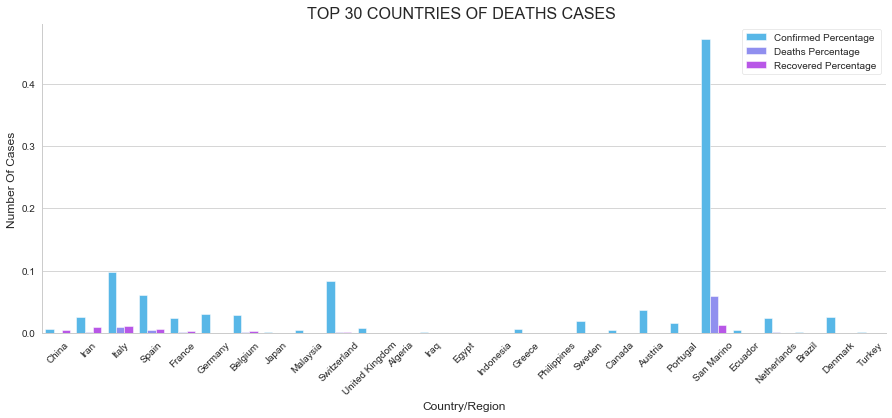

In [96]:
df9 = df7[df7['Country/Region'].isin(top_deaths_list) ]
df9.head()

sns.set_style('whitegrid')
g = sns.catplot(data=df9, x='Country/Region', y='Number Of Cases',
                           hue='Types', kind="bar", palette='cool', height=5, aspect = 2.5, legend = False)
plt.title('TOP 30 COUNTRIES OF DEATHS CASES ', size=16)
plt.legend(loc='upper right');
g.set_xticklabels(rotation=45);

In [97]:
# df8_population = df_2020[df_2020['Location'].isin(top_confirmed_list)]
# df8_population.head()

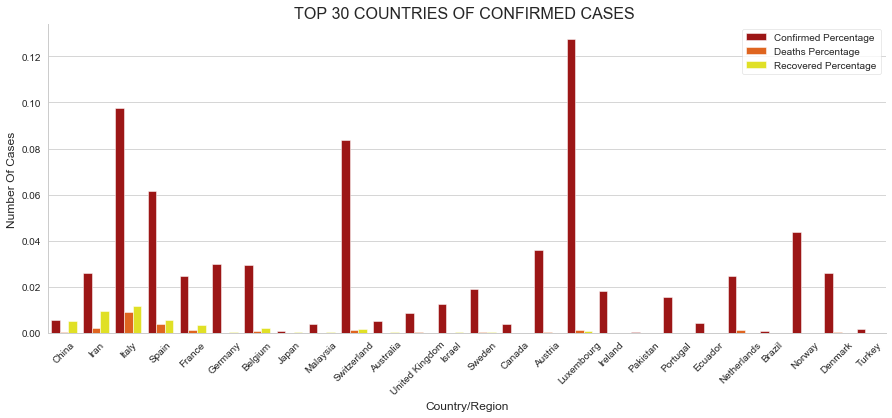

In [98]:
sns.set_style('whitegrid')
g = sns.catplot(data=df8, x='Country/Region', y='Number Of Cases',
                           hue='Types', kind="bar", palette='hot', height=5, aspect = 2.5, legend = False)
plt.title('TOP 30 COUNTRIES OF CONFIRMED CASES ', size=16)
plt.legend(loc='upper right');
g.set_xticklabels(rotation=45);

In [99]:
# df10_population = df_2020[df_2020['Location'].isin(top_recovered_list)]
# df10_population.head()

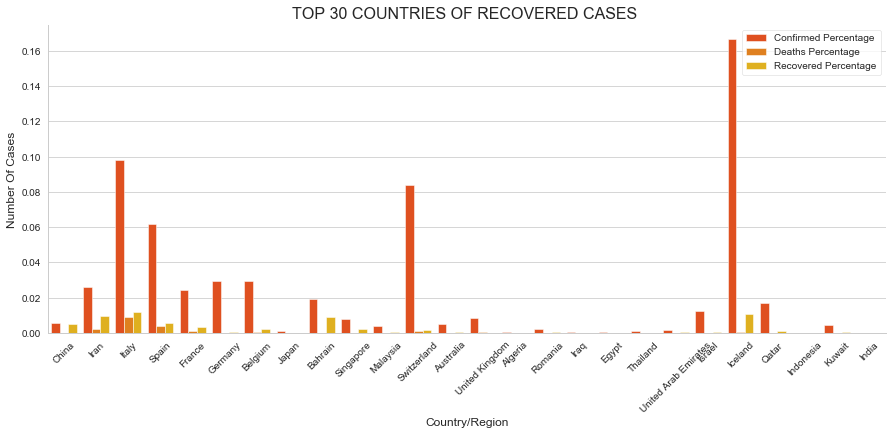

In [100]:
df10 = df7[df7['Country/Region'].isin(top_recovered_list) ]
df10.head()

sns.set_style('whitegrid')
g = sns.catplot(data=df10, x='Country/Region', y='Number Of Cases',
                           hue='Types', kind="bar", palette='autumn', height=5, aspect = 2.5, legend = False)
plt.title('TOP 30 COUNTRIES OF RECOVERED CASES ', size=16)
plt.legend(loc='upper right');
g.set_xticklabels(rotation=45);

In [101]:
# top30_recovered.reset_index(inplace = True)
# sns.set_style('whitegrid')
# g = sns.catplot(x='Country/Region', y='current_recovered', data=top30_recovered,
#                 kind='bar', palette='autumn', height=6, aspect=2.5, legend = False)
# plt.legend(loc='upper right');
# g.set_xticklabels(rotation=45);

### STEP 5: RESHAPE FROM WIDE TO LONG FORMAT

In [102]:
def melt_data(df):
    """
    melt data of one zip code from wide format to long format
    """
    
    melted = pd.melt(df, id_vars=['Country/Region'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    #melted = melted.dropna(subset=['value'])
    
    return melted.groupby('time').aggregate({'value':'mean'})

In [103]:
def melt_df(df):
    """
    Loop through all zipcodes to melt data of each zipcode.
    Then, merge all melted data back together
    """
    
    merged = []
    for country in df['Country/Region']:
        melted = melt_data(df.loc[df['Country/Region'] == country])
        row = df.loc[df['Country/Region'] == country].iloc[:,:1]
        rows = pd.concat([row]*len(melted), ignore_index=True)
        merge = pd.concat([rows, melted.reset_index()], axis= 1)
        merged.append(merge)
    melted_df = pd.concat(merged)
    return melted_df

In [104]:
sorted_df_confirmed.reset_index(inplace=True)

In [105]:
sorted_df_confirmed.head()

Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
0    Afghanistan        0        0        0        0        0        0   
1        Albania        0        0        0        0        0        0   
2        Algeria        0        0        0        0        0        0   
3        Andorra        0        0        0        0        0        0   
4         Angola        0        0        0        0        0        0   

   1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  \
0        0        0        0        0       0       0       0       0       0   
1        0        0        0        0       0       0       0       0       0   
2        0        0        0        0       0       0       0       0       0   
3        0        0        0        0       0       0       0       0       0   
4        0        0        0        0       0       0       0       0       0   

   2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  \
0       0       0       0       0        0        0        0        0   
1       0       0       0       0        0        0        0        0   
2       0       0       0       0        0        0        0        0   
3       0       0       0       0        0        0        0        0   
4       0       0       0       0        0        0        0        0   

   2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  \
0        0        0        1        1        1        1        1        1   
1        0        0        0        0        0        0        0        0   
2        0        0        0        1        1        1        1        1   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  \
0       1       1       1       1       1       1       1       4       4   
1       0       0       0       0       0       0       0       0       2   
2       1       3       5      12      12      17      17      19      20   
3       0       1       1       1       1       1       1       1       1   
4       0       0       0       0       0       0       0       0       0   

   3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  \
0        5        7        7        7       11       16       21       22   
1       10       12       23       33       38       42       51       55   
2       20       20       24       26       37       48       54       60   
3        1        1        1        1        1        1        2       39   
4        0        0        0        0        0        0        0        0   

   3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  3/23/20  
0       22       22       24       24       40     40.0  
1       59       64       70       76       89     89.0  
2       74       87       90      139      201    201.0  
3       39       53       75       88      113    113.0  
4        0        0        1        2        2      2.0

In [106]:
df = melt_df(sorted_df_confirmed)

In [107]:
df.head()

Country/Region       time  value
0    Afghanistan 2020-01-22    0.0
1    Afghanistan 2020-01-23    0.0
2    Afghanistan 2020-01-24    0.0
3    Afghanistan 2020-01-25    0.0
4    Afghanistan 2020-01-26    0.0

In [108]:
# check any columns has na/nan value, if there is missing data
#### forward fill missing value
#df['time'] = df['time'].ffill()
df.isnull().any()

Country/Region    False
time              False
value             False
dtype: bool

#### Convert to Time Series Data by setting the time column as the index

In [109]:
# make it as time series
df.set_index('time', inplace=True)

In [110]:
# look at the head again
df.head()

Country/Region  value
time                            
2020-01-22    Afghanistan    0.0
2020-01-23    Afghanistan    0.0
2020-01-24    Afghanistan    0.0
2020-01-25    Afghanistan    0.0
2020-01-26    Afghanistan    0.0

In [111]:
# check any columns has na/nan value, if there is missing data
df.isnull().any()

Country/Region    False
value             False
dtype: bool

#### Now we see no more missing value in any column. Change the name of feature. Take a look at the final dataframe before performing EDA

In [112]:
# rename columns
df.rename(columns={'Country/Region': 'Country'}, inplace=True)
df.head()

Country  value
time                          
2020-01-22  Afghanistan    0.0
2020-01-23  Afghanistan    0.0
2020-01-24  Afghanistan    0.0
2020-01-25  Afghanistan    0.0
2020-01-26  Afghanistan    0.0

In [113]:
df.tail()

Country  value
time                       
2020-03-19  Zimbabwe    0.0
2020-03-20  Zimbabwe    1.0
2020-03-21  Zimbabwe    3.0
2020-03-22  Zimbabwe    3.0
2020-03-23  Zimbabwe    3.0

In [114]:
df

Country   value
time                                    
2020-01-22           Afghanistan     0.0
2020-01-23           Afghanistan     0.0
2020-01-24           Afghanistan     0.0
2020-01-25           Afghanistan     0.0
2020-01-26           Afghanistan     0.0
2020-01-27           Afghanistan     0.0
2020-01-28           Afghanistan     0.0
2020-01-29           Afghanistan     0.0
2020-01-30           Afghanistan     0.0
2020-01-31           Afghanistan     0.0
2020-02-01           Afghanistan     0.0
2020-02-02           Afghanistan     0.0
2020-02-03           Afghanistan     0.0
2020-02-04           Afghanistan     0.0
2020-02-05           Afghanistan     0.0
2020-02-06           Afghanistan     0.0
2020-02-07           Afghanistan     0.0
2020-02-08           Afghanistan     0.0
2020-02-09           Afghanistan     0.0
2020-02-10           Afghanistan     0.0
2020-02-11           Afghanistan     0.0
2020-02-12           Afghanistan     0.0
2020-02-13           Afghanistan     0.0
2020-02-14           Afghanistan     0.0
2020-02-15           Afghanistan     0.0
2020-02-16           Afghanistan     0.0
2020-02-17           Afghanistan     0.0
2020-02-18           Afghanistan     0.0
2020-02-19           Afghanistan     0.0
2020-02-20           Afghanistan     0.0
2020-02-21           Afghanistan     0.0
2020-02-22           Afghanistan     0.0
2020-02-23           Afghanistan     0.0
2020-02-24           Afghanistan     1.0
2020-02-25           Afghanistan     1.0
2020-02-26           Afghanistan     1.0
2020-02-27           Afghanistan     1.0
2020-02-28           Afghanistan     1.0
2020-02-29           Afghanistan     1.0
2020-03-01           Afghanistan     1.0
2020-03-02           Afghanistan     1.0
2020-03-03           Afghanistan     1.0
2020-03-04           Afghanistan     1.0
2020-03-05           Afghanistan     1.0
2020-03-06           Afghanistan     1.0
2020-03-07           Afghanistan     1.0
2020-03-08           Afghanistan     4.0
2020-03-09           Afghanistan     4.0
2020-03-10           Afghanistan     5.0
2020-03-11           Afghanistan     7.0
2020-03-12           Afghanistan     7.0
2020-03-13           Afghanistan     7.0
2020-03-14           Afghanistan    11.0
2020-03-15           Afghanistan    16.0
2020-03-16           Afghanistan    21.0
2020-03-17           Afghanistan    22.0
2020-03-18           Afghanistan    22.0
2020-03-19           Afghanistan    22.0
2020-03-20           Afghanistan    24.0
2020-03-21           Afghanistan    24.0
2020-03-22           Afghanistan    40.0
2020-03-23           Afghanistan    40.0
2020-01-22               Albania     0.0
2020-01-23               Albania     0.0
2020-01-24               Albania     0.0
2020-01-25               Albania     0.0
2020-01-26               Albania     0.0
2020-01-27               Albania     0.0
2020-01-28               Albania     0.0
2020-01-29               Albania     0.0
2020-01-30               Albania     0.0
2020-01-31               Albania     0.0
2020-02-01               Albania     0.0
2020-02-02               Albania     0.0
2020-02-03               Albania     0.0
2020-02-04               Albania     0.0
2020-02-05               Albania     0.0
2020-02-06               Albania     0.0
2020-02-07               Albania     0.0
2020-02-08               Albania     0.0
2020-02-09               Albania     0.0
2020-02-10               Albania     0.0
2020-02-11               Albania     0.0
2020-02-12               Albania     0.0
2020-02-13               Albania     0.0
2020-02-14               Albania     0.0
2020-02-15               Albania     0.0
2020-02-16               Albania     0.0
2020-02-17               Albania     0.0
2020-02-18               Albania     0.0
2020-02-19               Albania     0.0
2020-02-20               Albania     0.0
2020-02-21               Albania     0.0
2020-02-22               Albania     0.0
2020-02-23               Albania     0.0
2020-02-24               Albania     0.0
2020-02

# Step 2: EDA and Visualization

#### Visualization of data at a glance, just to see the whole picture of corona virus spreading.

In [115]:
# countries affected
countries = df['Country'].unique()
len(countries)

183

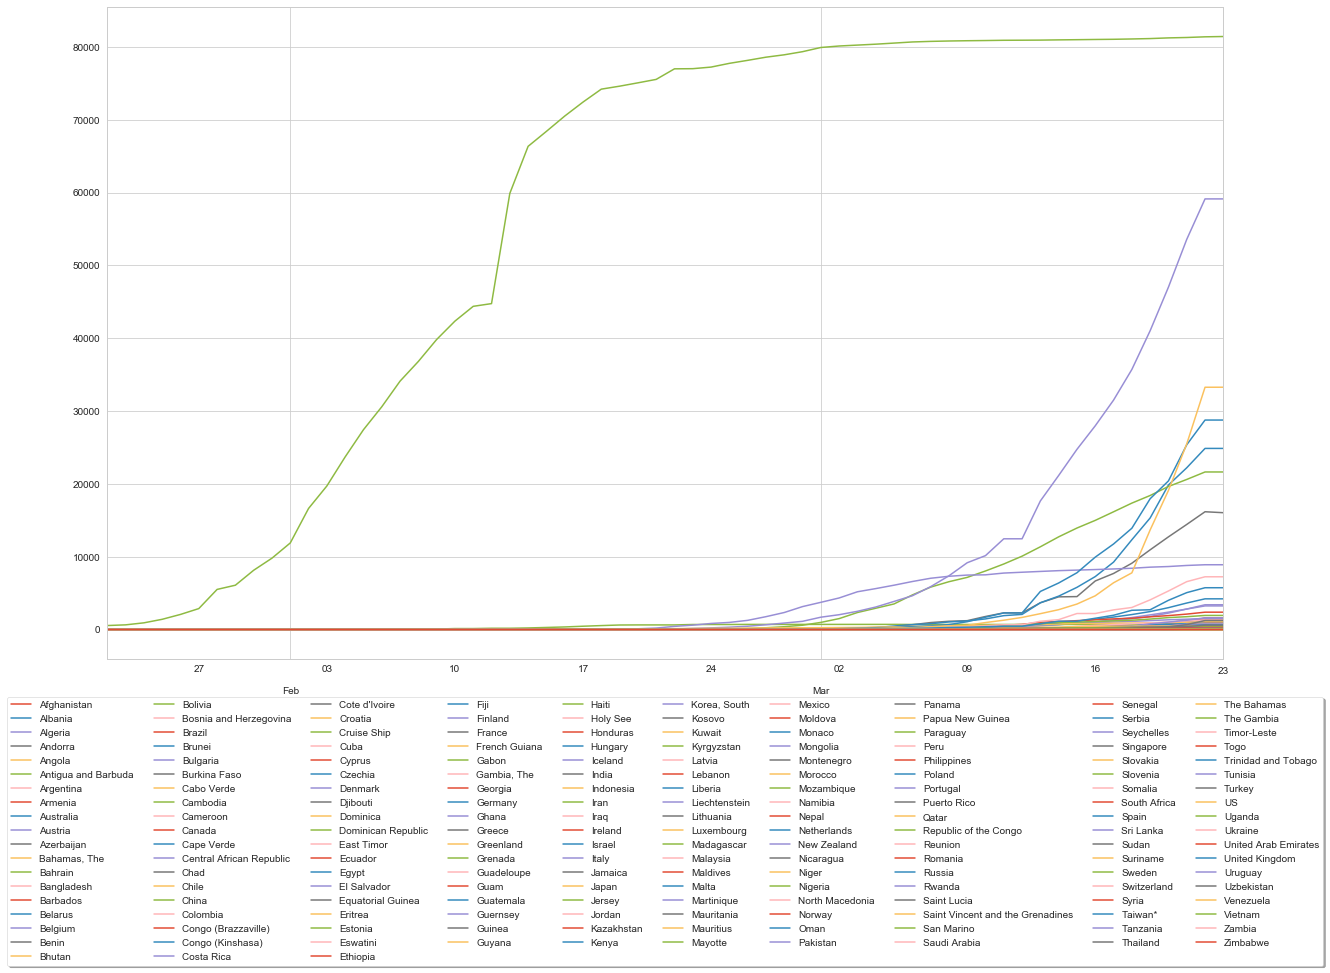

In [116]:
plt.figure(figsize=(20,12))

for c in countries:
    df[df['Country']==c]['value'].plot(label=c)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=10)
plt.show()

### From a quick plot above, we see that the corona virus had started and spreaded widely from China since Jan 22, 2020. There are some countries had started slightly from Feb 20 and the corona virus were actually growing much faster over time. Jan 26, 2020 the spreading speed has increased significantly in some countries such as Singapore, Spain, Iran, Italy . Mar 10, 2020 the corona virus has been spreading out crazily in other countries while there is no new confirmed case. 

#### Run an ETS Decomposition

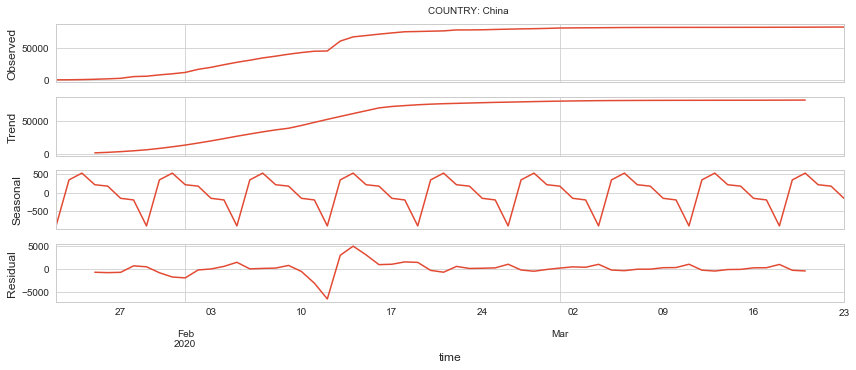

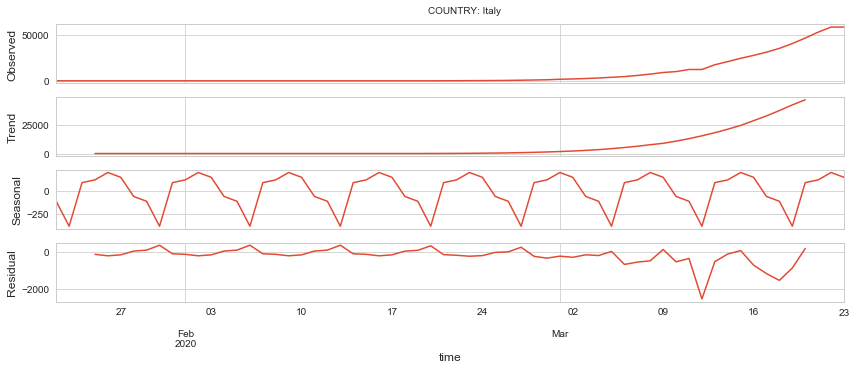

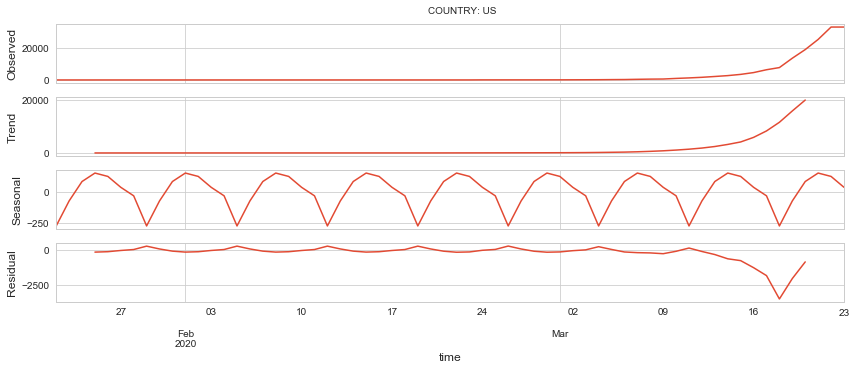

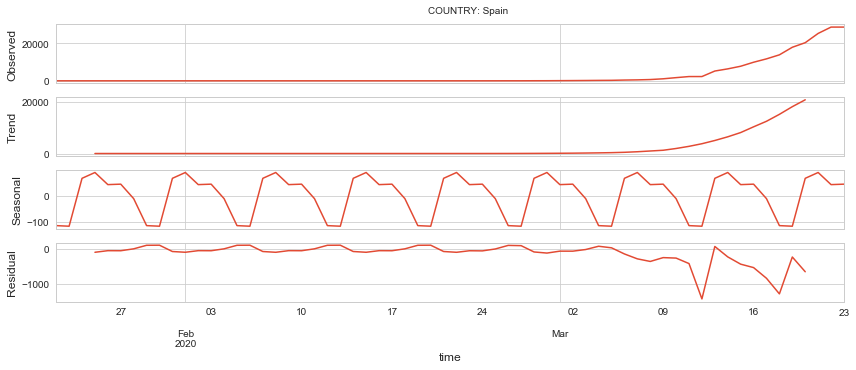

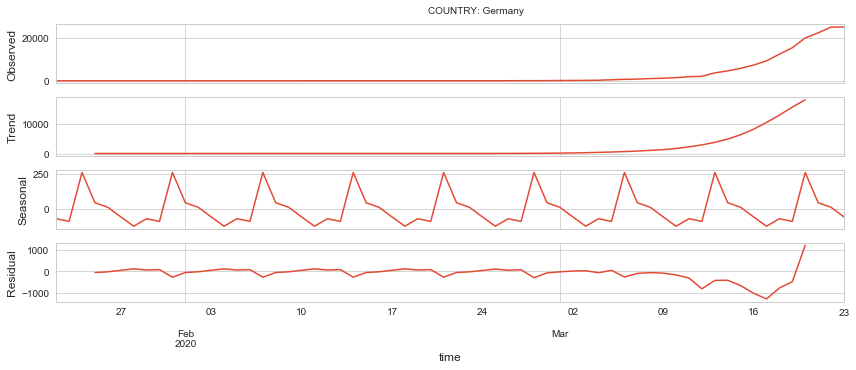

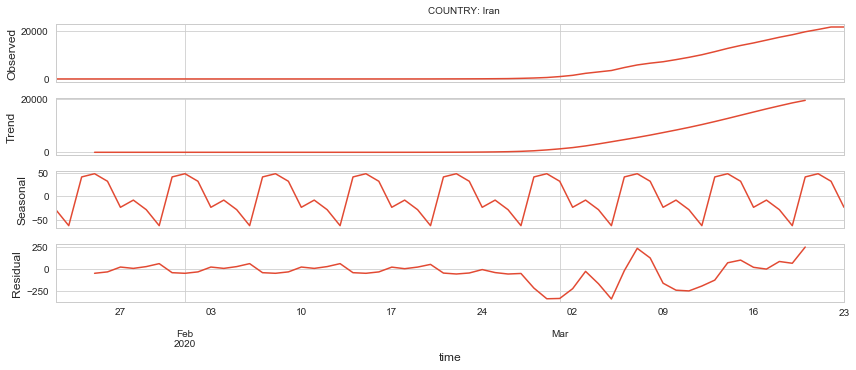

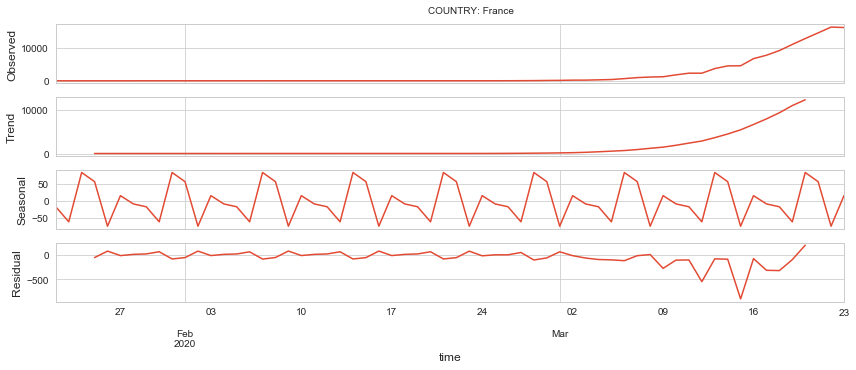

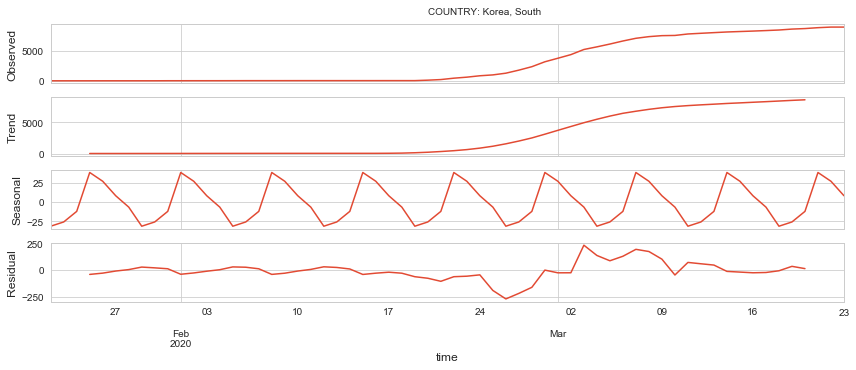

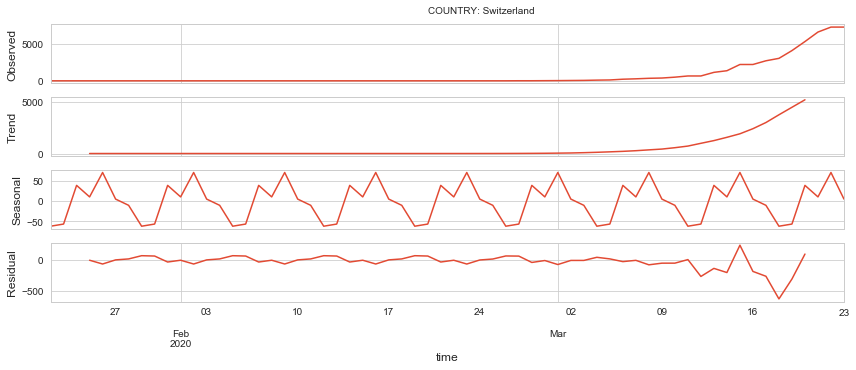

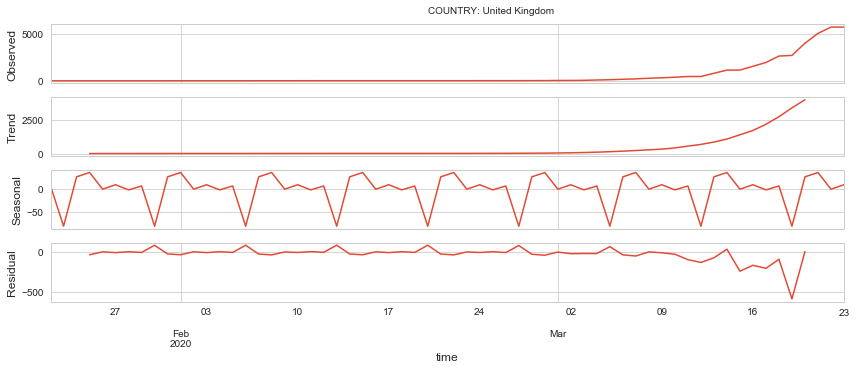

In [117]:
rcParams['figure.figsize'] = 12,5

for country in top_confirmed_list[0:10]:
    results = seasonal_decompose(df.loc[df['Country'] == country].value, model='add')
    fig = results.plot();
    fig.text(0.5, 1, f'COUNTRY: {country}')

#### Plot ACF and PACF of some zipcodes to check corelation

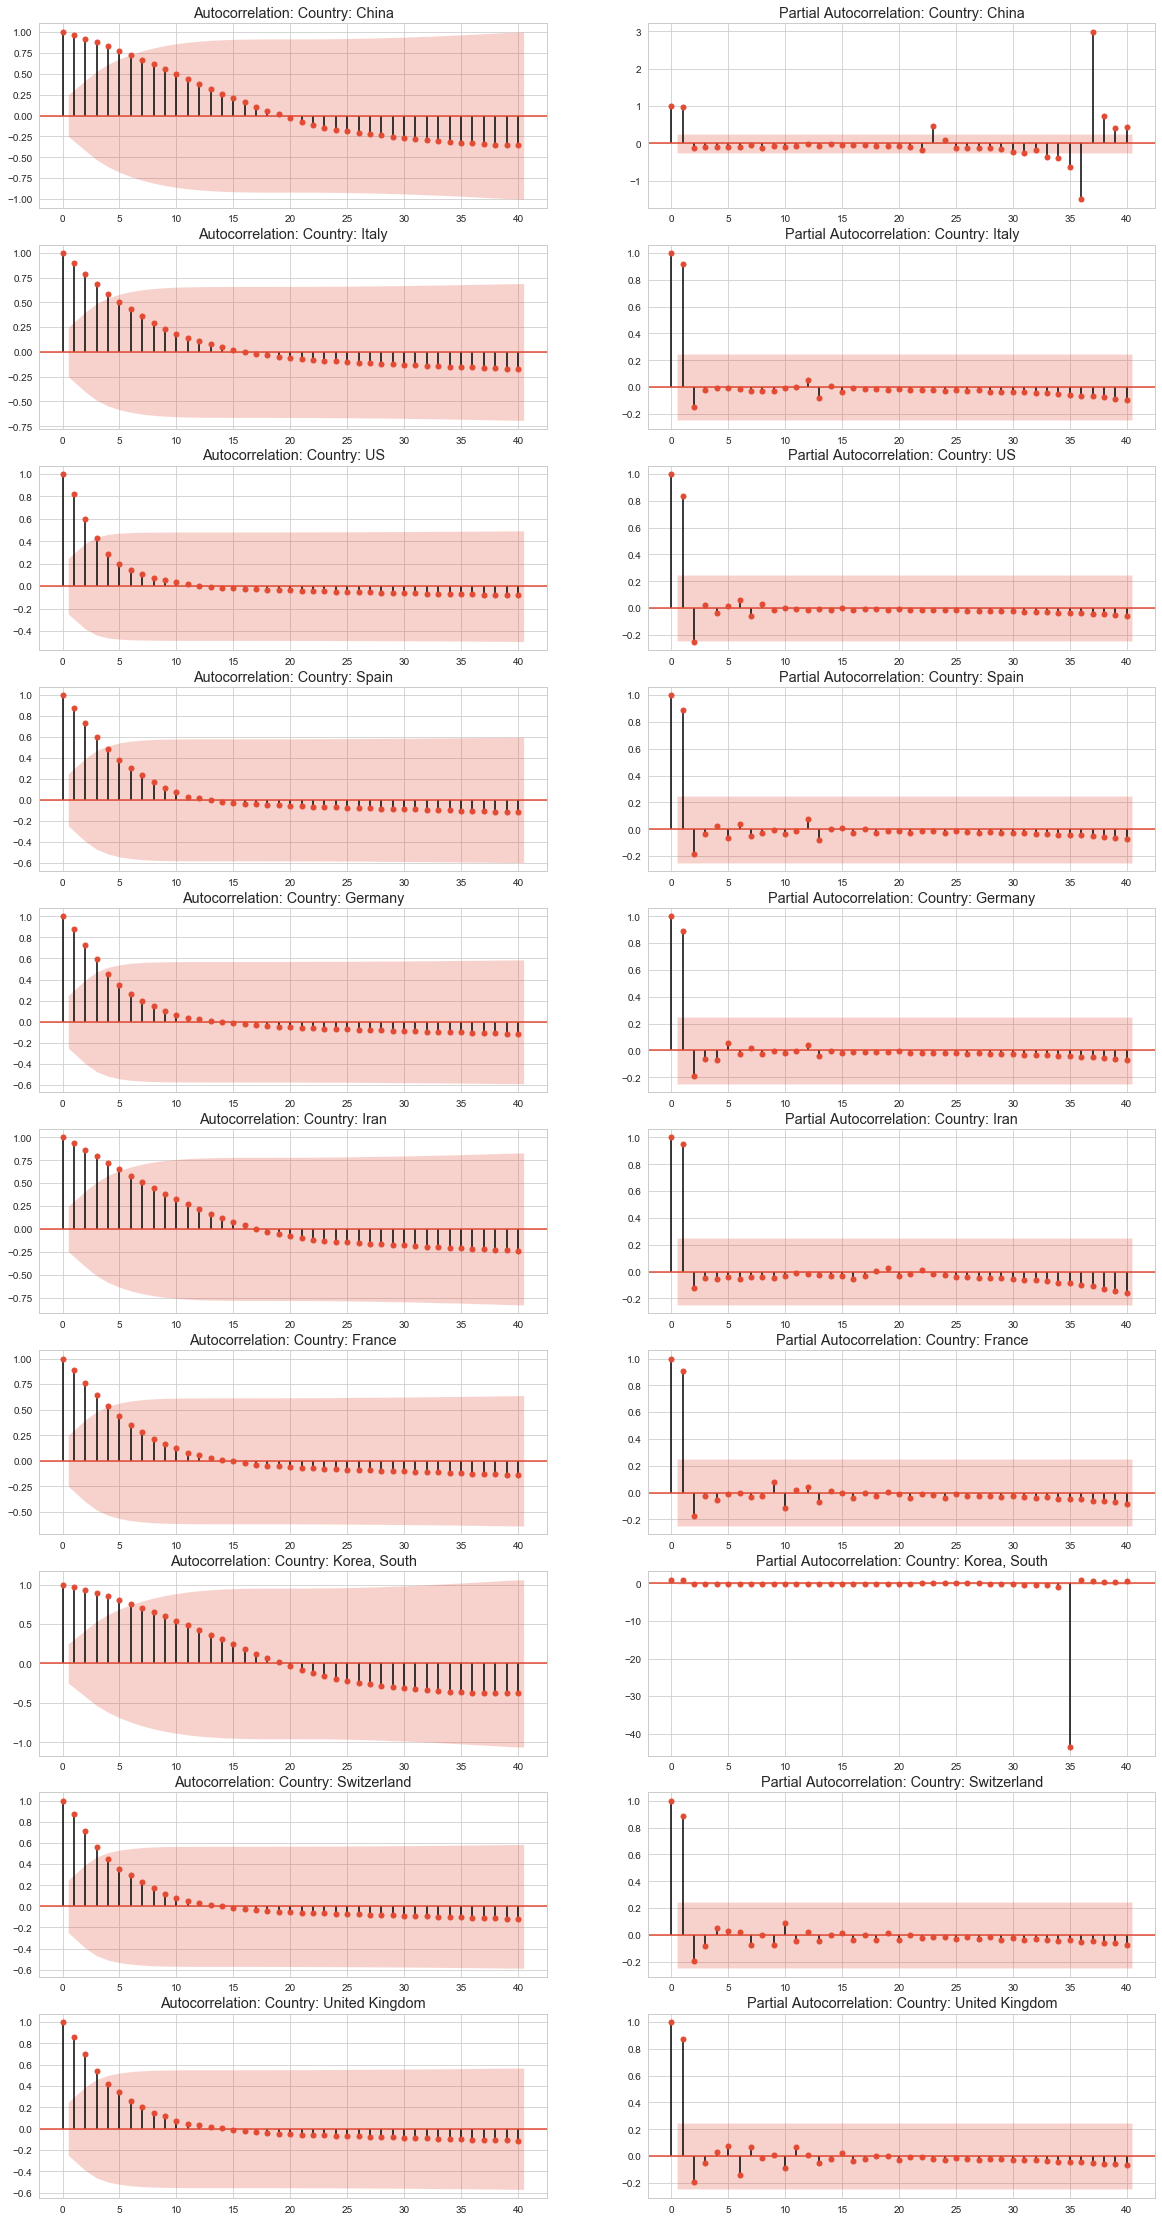

In [118]:
fig = plt.figure(figsize=(20,40))
i = 0
lags=40
for country in top_confirmed_list[0:10]:
    i += 1
    ax = plt.subplot(10,2,i)
    title = f'Autocorrelation: Country: {country}'
    plot_acf(df.loc[df['Country'] == country].value, alpha=0.05, title=title, lags=lags, ax=ax);

    i += 1
    ax = plt.subplot(10,2,i)
    title=f'Partial Autocorrelation: Country: {country}'
    plot_pacf(df.loc[df['Country'] == country].value, alpha=0.05, title=title, lags=lags, ax=ax);

## Automate the Augmented Dickey-Fuller Test
##### Function that performs the augmented Dickey-Fuller Test to determine if an incoming time series is stationary.

In [119]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print("==============================================================")
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print("--------------------------------------------------------------")
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
    print("--------------------------------------------------------------")

In [120]:
# check ADF test for some zipcodes
for country in top_confirmed_list[0:10]:
    adf_test(df.loc[df['Country'] == country].value, title= f'COUNTRY: {country}')

Augmented Dickey-Fuller Test: COUNTRY: China
--------------------------------------------------------------
ADF test statistic      -2.344141
p-value                  0.158127
# lags used              1.000000
# observations          60.000000
critical value (1%)     -3.544369
critical value (5%)     -2.911073
critical value (10%)    -2.593190
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
--------------------------------------------------------------
Augmented Dickey-Fuller Test: COUNTRY: Italy
--------------------------------------------------------------
ADF test statistic     -1.215324e+01
p-value                 1.552890e-22
# lags used             9.000000e+00
# observations          5.200000e+01
critical value (1%)    -3.562879e+00
critical value (5%)    -2.918973e+00
critical value (10%)   -2.597393e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stat

### With the Augmented Dickey-Fuller Test results, all data for all zipcodes are non-staytionary. except Italy

# STEP 8: Explore ARIMA Modeling to Find Best Fit Model

### Use grid search to find best fit ARIMA model of one sample country

In [121]:
# One sample test zipcode
country = top_confirmed_list[0]
country

'China'

In [122]:
# test with one zipcode
result = auto_arima(df.loc[df['Country'] == country].value, 
                    start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=False, d=None, D=1, 
                    trace=False, error_action='ignore',suppress_warnings=True, stepwise=True)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                   60
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -541.937
Method:                       css-mle   S.D. of innovations           2012.784
Date:                Mon, 23 Mar 2020   AIC                           1089.875
Time:                        21:24:21   BIC                           1096.158
Sample:                             2   HQIC                          1092.332
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.8610     76.507     -0.155      0.877    -161.812     138.090
ma.L1.D2.y    -0.7195      0.100     -7.165      0.000      -0.916      -0.523
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.3899           +0.0000j            1.3899            0.0000
-----------------------------------------------------------------------------
"""

### After having the best-fit model from auto_arima grid search, we double check with visualization of ETS decomposition and ACF and PACF

Text(0.5, 1, 'COUNTRY: China')

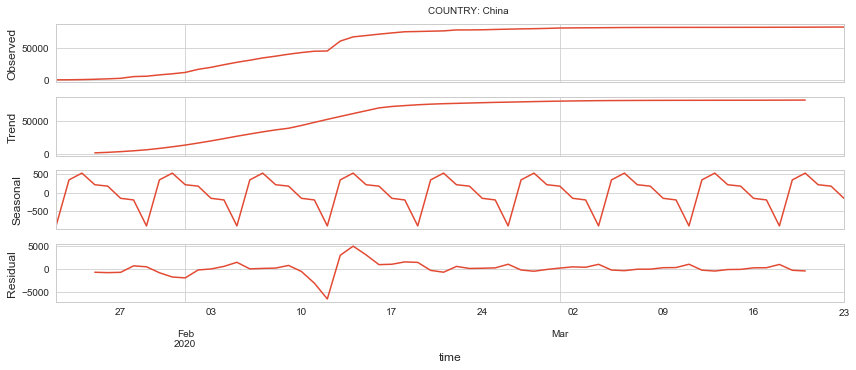

In [123]:
rcParams['figure.figsize'] = 12,5
results = seasonal_decompose(df.loc[df['Country'] == country].value, model='add')
fig = results.plot();
fig.text(0.5,1,f'COUNTRY: {country}')

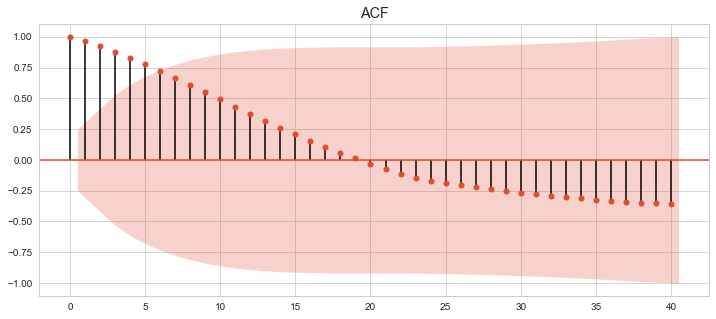

In [124]:
plot_acf(df.loc[df['Country'] == country].value,alpha=0.05,title='ACF',lags=40);

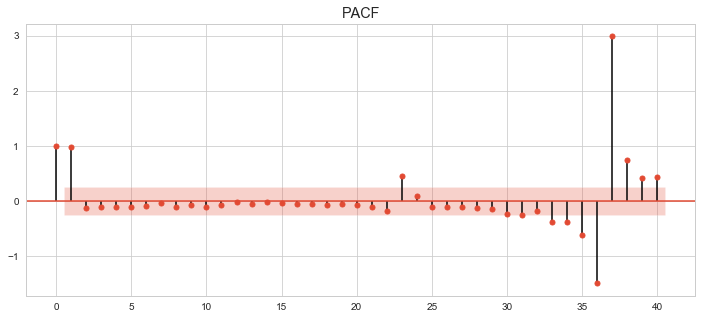

In [125]:
plot_pacf(df.loc[df['Country'] == country].value,alpha=0.05,title='PACF',lags=40);

#### Again, the ACF & PACF plots confirm the zipcode has none seasonality.

### Now, we wrote code to find best-fit models for a list of countries and store the fitted models in to a DataFrame for later dispaly and use
#### For quick testing purpose we only need to test with one country, but we can do for all countries

In [126]:
# find the best fit model for the first test country
models = []
for country in top_confirmed_list[0:1]:
    result = auto_arima(df.loc[df['Country'] == country].value, 
                    start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=False, d=None, D=1, 
                    trace=False, error_action='ignore',suppress_warnings=True, stepwise=True)
    if result._is_seasonal():
        model = {'Country': country, 'model': 'SARIMAX', 'order': result.order,
                                     'seasonal_order': result.seasonal_order}
    else:
        model = {'Country': country, 'model': 'ARIMA', 'order': result.order, 
                                     'seasonal_order': None}
        
    models.append(model)
    
# convert models list into DataFrame for easy reading
model_df = pd.DataFrame(models, columns=['zipcode', 'model', 'order', 'seasonal_order'])
model_df

zipcode  model      order seasonal_order
0      NaN  ARIMA  (0, 2, 1)           None

#### After having the model, we split data of this country into train/test dataset to evaluate the accurateness of the model

In [127]:
first_country_data = df[df['Country']==country]
first_country_data.head()

Country   value
time                      
2020-01-22   China   548.0
2020-01-23   China   643.0
2020-01-24   China   920.0
2020-01-25   China  1406.0
2020-01-26   China  2075.0

In [128]:
# get tail data of 3 year - test data set
first_country_data.tail(36)

Country    value
time                       
2020-02-17   China  72434.0
2020-02-18   China  74211.0
2020-02-19   China  74619.0
2020-02-20   China  75077.0
2020-02-21   China  75550.0
2020-02-22   China  77001.0
2020-02-23   China  77022.0
2020-02-24   China  77241.0
2020-02-25   China  77754.0
2020-02-26   China  78166.0
2020-02-27   China  78600.0
2020-02-28   China  78928.0
2020-02-29   China  79356.0
2020-03-01   China  79932.0
2020-03-02   China  80136.0
2020-03-03   China  80261.0
2020-03-04   China  80386.0
2020-03-05   China  80537.0
2020-03-06   China  80690.0
2020-03-07   China  80770.0
2020-03-08   China  80823.0
2020-03-09   China  80860.0
2020-03-10   China  80887.0
2020-03-11   China  80921.0
2020-03-12   China  80932.0
2020-03-13   China  80945.0
2020-03-14   China  80977.0
2020-03-15   China  81003.0
2020-03-16   China  81033.0
2020-03-17   China  81058.0
2020-03-18   China  81102.0
2020-03-19   China  81156.0
2020-03-20   China  81250.0
2020-03-21   China  81305.0
2020-03-22   China  81397.0
2020-03-23   China  81439.0

In [165]:
# Calculate the split time point for train & test data.
now = datetime.now()
start_date = datetime(2020, 1, 22)
end_date = now
delta = end_date - start_date
train_days = round(delta.days * 0.7)
split_date = start_date + timedelta(days=train_days)

start_date = start_date.date()
end_date = end_date.date()
split_date = split_date.date()

print(start_date)
print(split_date)
print(end_date)

2020-01-22
2020-03-05
2020-03-23


In [145]:
# split train/test data
#train_df = first_country_data.iloc[:train_days] #
train_df = first_country_data.loc[:split_date]
#test_df = first_country_data.iloc[split_date:]  #
test_start_date = split_date + timedelta(days=1) 
test_df = first_country_data.loc[test_start_date:]

In [146]:
train_df.tail()

Country    value
time                       
2020-03-01   China  79932.0
2020-03-02   China  80136.0
2020-03-03   China  80261.0
2020-03-04   China  80386.0
2020-03-05   China  80537.0

In [147]:
test_df.head()

Country    value
time                       
2020-03-06   China  80690.0
2020-03-07   China  80770.0
2020-03-08   China  80823.0
2020-03-09   China  80860.0
2020-03-10   China  80887.0

In [132]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43 entries, 2020-01-22 to 2020-03-04
Data columns (total 2 columns):
Country    43 non-null object
value      43 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.0+ KB


In [133]:
test_df

Country    value
time                       
2020-03-06   China  80690.0
2020-03-07   China  80770.0
2020-03-08   China  80823.0
2020-03-09   China  80860.0
2020-03-10   China  80887.0
2020-03-11   China  80921.0
2020-03-12   China  80932.0
2020-03-13   China  80945.0
2020-03-14   China  80977.0
2020-03-15   China  81003.0
2020-03-16   China  81033.0
2020-03-17   China  81058.0
2020-03-18   China  81102.0
2020-03-19   China  81156.0
2020-03-20   China  81250.0
2020-03-21   China  81305.0
2020-03-22   China  81397.0
2020-03-23   China  81439.0

In [134]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18 entries, 2020-03-06 to 2020-03-23
Data columns (total 2 columns):
Country    18 non-null object
value      18 non-null float64
dtypes: float64(1), object(1)
memory usage: 432.0+ bytes


In [148]:
# fit the best model with full historical data for one test zipcode
arima_model = sm.tsa.statespace.SARIMAX(train_df['value'], 
                                        enforce_stationarity=False, enforce_invertibility=False)

# fit the model and print results
fitted_model = arima_model.fit()

#### Printing the diagnostics of the model

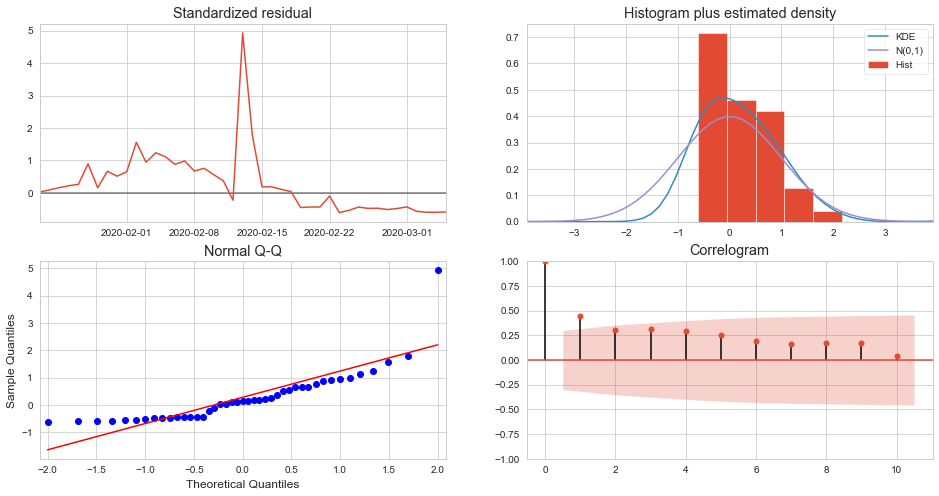

In [149]:
# plot model diagnostics
fitted_model.plot_diagnostics(figsize=(16, 8))
plt.show()

#### Evaluate the prediction and the test data

In [167]:
# forecast the test data
forecast_values = fitted_model.predict(start=test_start_date, end=end_date, 
                                       typ='levels', dynamic=True).rename('predict')

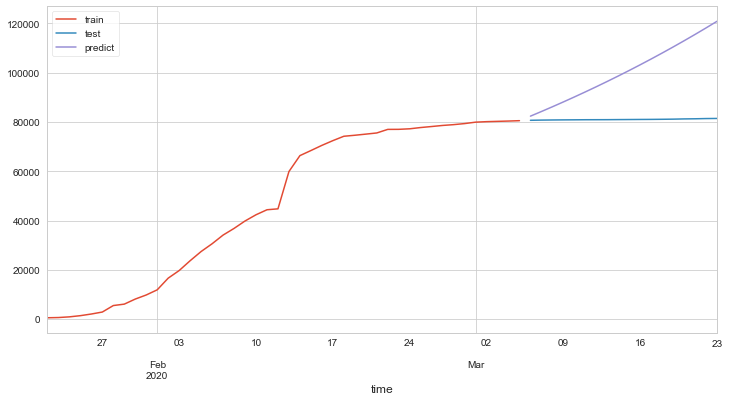

In [168]:
# plot historical and forecasted data
train_df['train'] = train_df['value']
train_df['train'].plot(legend=True,figsize=(12,6))
test_df['test'] = test_df['value']
test_df['test'].plot(legend=True)
forecast_values.plot(legend=True);


In [169]:
# find the best fit model for the first test country
models = []
for country in top_confirmed_list[1:2]:
    result = auto_arima(df.loc[df['Country'] == country].value, 
                    start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=False, d=None, D=1, 
                    trace=False, error_action='ignore',suppress_warnings=True, stepwise=True)
    if result._is_seasonal():
        model = {'Country': country, 'model': 'SARIMAX', 'order': result.order,
                                     'seasonal_order': result.seasonal_order}
    else:
        model = {'Country': country, 'model': 'ARIMA', 'order': result.order, 
                                     'seasonal_order': None}
        
    models.append(model)
    
# convert models list into DataFrame for easy reading
model_df = pd.DataFrame(models, columns=['zipcode', 'model', 'order', 'seasonal_order'])
model_df

zipcode  model      order seasonal_order
0      NaN  ARIMA  (0, 2, 1)           None

#### After having the model, we split data of this country into train/test dataset to evaluate the accurateness of the model

In [171]:
second_country_data = df[df['Country']==country]
second_country_data.head()

Country  value
time                     
2020-01-22   Italy    0.0
2020-01-23   Italy    0.0
2020-01-24   Italy    0.0
2020-01-25   Italy    0.0
2020-01-26   Italy    0.0

In [172]:
# get tail data of 3 year - test data set
second_country_data.tail(36)

Country    value
time                       
2020-02-17   Italy      3.0
2020-02-18   Italy      3.0
2020-02-19   Italy      3.0
2020-02-20   Italy      3.0
2020-02-21   Italy     20.0
2020-02-22   Italy     62.0
2020-02-23   Italy    155.0
2020-02-24   Italy    229.0
2020-02-25   Italy    322.0
2020-02-26   Italy    453.0
2020-02-27   Italy    655.0
2020-02-28   Italy    888.0
2020-02-29   Italy   1128.0
2020-03-01   Italy   1694.0
2020-03-02   Italy   2036.0
2020-03-03   Italy   2502.0
2020-03-04   Italy   3089.0
2020-03-05   Italy   3858.0
2020-03-06   Italy   4636.0
2020-03-07   Italy   5883.0
2020-03-08   Italy   7375.0
2020-03-09   Italy   9172.0
2020-03-10   Italy  10149.0
2020-03-11   Italy  12462.0
2020-03-12   Italy  12462.0
2020-03-13   Italy  17660.0
2020-03-14   Italy  21157.0
2020-03-15   Italy  24747.0
2020-03-16   Italy  27980.0
2020-03-17   Italy  31506.0
2020-03-18   Italy  35713.0
2020-03-19   Italy  41035.0
2020-03-20   Italy  47021.0
2020-03-21   Italy  53578.0
2020-03-22   Italy  59138.0
2020-03-23   Italy  59138.0

In [173]:
# split train/test data
#train_df = first_country_data.iloc[:train_days] #
train_df2 = first_country_data.loc[:split_date]
#test_df = first_country_data.iloc[split_date:]  #
test_start_date = split_date + timedelta(days=1) 
test_df2 = first_country_data.loc[test_start_date:]

In [174]:
train_df2.tail()

Country   value
time                      
2020-03-01   Italy  1694.0
2020-03-02   Italy  2036.0
2020-03-03   Italy  2502.0
2020-03-04   Italy  3089.0
2020-03-05   Italy  3858.0

In [175]:
test_df2.head()

Country    value
time                       
2020-03-06   Italy   4636.0
2020-03-07   Italy   5883.0
2020-03-08   Italy   7375.0
2020-03-09   Italy   9172.0
2020-03-10   Italy  10149.0

In [176]:
train_df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2020-01-22 to 2020-03-05
Data columns (total 2 columns):
Country    44 non-null object
value      44 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.0+ KB


In [177]:
test_df2

Country    value
time                       
2020-03-06   Italy   4636.0
2020-03-07   Italy   5883.0
2020-03-08   Italy   7375.0
2020-03-09   Italy   9172.0
2020-03-10   Italy  10149.0
2020-03-11   Italy  12462.0
2020-03-12   Italy  12462.0
2020-03-13   Italy  17660.0
2020-03-14   Italy  21157.0
2020-03-15   Italy  24747.0
2020-03-16   Italy  27980.0
2020-03-17   Italy  31506.0
2020-03-18   Italy  35713.0
2020-03-19   Italy  41035.0
2020-03-20   Italy  47021.0
2020-03-21   Italy  53578.0
2020-03-22   Italy  59138.0
2020-03-23   Italy  59138.0

In [178]:
test_df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18 entries, 2020-03-06 to 2020-03-23
Data columns (total 2 columns):
Country    18 non-null object
value      18 non-null float64
dtypes: float64(1), object(1)
memory usage: 432.0+ bytes


In [179]:
# fit the best model with full historical data for one test zipcode
arima_model = sm.tsa.statespace.SARIMAX(train_df2['value'], 
                                        enforce_stationarity=False, enforce_invertibility=False)

# fit the model and print results
fitted_model = arima_model.fit()

#### Printing the diagnostics of the model

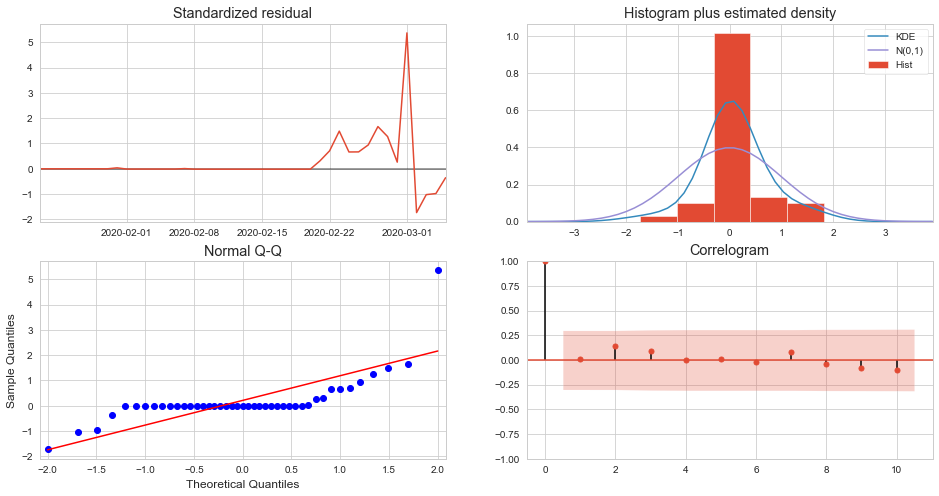

In [180]:
# plot model diagnostics
fitted_model.plot_diagnostics(figsize=(16, 8))
plt.show()

#### Evaluate the prediction and the test data

In [181]:
# forecast the test data
forecast_values = fitted_model.predict(start=test_start_date, end=end_date, 
                                       typ='levels', dynamic=True).rename('predict')

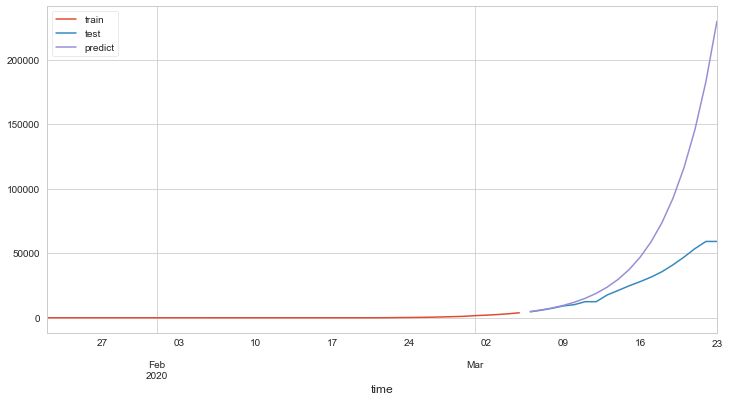

In [182]:
# plot historical and forecasted data
train_df2['train'] = train_df2['value']
train_df2['train'].plot(legend=True,figsize=(12,6))
test_df2['test'] = test_df2['value']
test_df2['test'].plot(legend=True)
forecast_values.plot(legend=True);


### Calculate prediction error

In [183]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test_df2['value'], forecast_values)
print(f'RMSE: {error}')

RMSE: 59305.7695066755


In [36]:
# calculate ROI, Profit
date_range = pd.date_range(start_date, periods=36, freq='MS')
forecast = pd.DataFrame(forecast_values, index=date_range[:])
value = train_df.iloc[-1]['value']
value_after_1_year = round(forecast.iloc[1*12-1]['predict'], 0)
value_after_2_year = round(forecast.iloc[2*12-1]['predict'], 0)
value_after_3_year = round(forecast.iloc[3*12-1]['predict'], 0)
forecast_data = {'Zipcode': zipcode, 'Current Value': value, 
                 'Value After 1 Year': value_after_1_year,
                 'Value After 2 Year': value_after_2_year,
                 'Value After 3 Year': value_after_3_year,
                 'Profit After 1 Year': value_after_1_year - value,
                 'Profit After 2 Year': value_after_2_year - value,
                 'Profit After 3 Year': value_after_3_year - value,
                 'ROI After 1 Year': round((value_after_1_year - value) / value, 2),
                 'ROI After 2 Year': round((value_after_2_year - value) / value, 2),
                 'ROI After 3 Year': round((value_after_3_year - value) / value, 2)}
forecast_data

{'Zipcode': 28269,
 'Current Value': 155200.0,
 'Value After 1 Year': 168977.0,
 'Value After 2 Year': 186806.0,
 'Value After 3 Year': 208684.0,
 'Profit After 1 Year': 13777.0,
 'Profit After 2 Year': 31606.0,
 'Profit After 3 Year': 53484.0,
 'ROI After 1 Year': 0.09,
 'ROI After 2 Year': 0.2,
 'ROI After 3 Year': 0.34}

# Step 5: Modelling and Forecasting The Future for All Zipcodes

#### Now we rewrite all the code for finding best models, fitting models and forecasting into reusable functions to perform forecasting for all the chosen zipcodes

In [37]:
# function to find best fit model
def find_best_fit_models(dataframe):
    """
    This function use auto_arima to find the best fit model for each zipcode
    provided in the ``zipcodes`` list.
    
    Parameters:
    ------------
    dataframe   : the house value time series DataFrame with columns: ['zipcode', 'value']
    
    Return:
    ------------
    A DataFrame with following data columns: ['zipcode', 'model', 'order', 'seasonal_order']
    """
    # list to store best fit models
    models = []
    
    # zipcodes
    zipcodes = dataframe['zipcode'].unique()
    
    # loop through all zipcodes to find best model for each zipcode
    for zipcode in zipcodes:
        # call auto_arima to find best model
        result = auto_arima(dataframe.loc[dataframe['zipcode'] == zipcode].value, 
                            start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=None, D=1, 
                            trace=False, error_action='ignore',suppress_warnings=True, stepwise=True)
        
        # build a model dictionary and put into the returned list
        model = {'zipcode': zipcode, 'model': 'SARIMAX', 'order': result.order, 'seasonal_order': result.seasonal_order}
        models.append(model)

    # convert models list into DataFrame for easy reading
    model_df = pd.DataFrame(models, columns=['zipcode', 'model', 'order', 'seasonal_order'])
    
    return model_df

In [38]:
# function to fit model and forecast future data
def fit_and_forecast(dataframe, model_df):
    """
    This function fit each model in ``model_df`` with the data from ``dataframe``.
    Then, use the fitted model to forecast into the future and calculate the forecasted ROI.
    
    Parameters:
    -----------
    dataframe   : the house value time series DataFrame with columns: ['zipcode', 'value']
    model_df    : the model DataFrame output from function ``find_best_fit_models``
    
    Return:
    -----------
    A DataFrame with forecasted data,
    And a DataFrame with forecasted ROI data
    """
    
    # forecast data to be returned
    ROIs = []
    forecasts = []
    
    # loop through all model in model_df
    for index, model in model_df.iterrows():                
        # fit the best model with full historical data for one test zipcode
        data = dataframe[dataframe['zipcode']==model['zipcode']]
        arima_model = sm.tsa.statespace.SARIMAX(data['value'], order=model['order'], 
                                                seasonal_order=model['seasonal_order'], 
                                                enforce_stationarity=False, enforce_invertibility=False)

        # fit the model and print results
        fitted_model = arima_model.fit()
    
        # last historical data point
        current_data = data.tail(1)
        current_data.reset_index(inplace=True)
        time = current_data.iloc[0]['time']
        zipcode = current_data.iloc[0]['zipcode']
        value = current_data.iloc[0]['value']
        
        # build forecast date range
        date_range = pd.date_range(time, periods=37, freq='MS') # first date is present
        date_range = date_range[1:] # remove the first date
        
        # forecast values of the future
        forecast_values = fitted_model.predict(start=date_range[0],
                  end=date_range[-1], typ='levels').rename('value')
        
        # build forecast dataframe
        forecast_df = pd.DataFrame(forecast_values, index=date_range[:])
        forecast_df['zipcode'] = zipcode
        forecasts.append(forecast_df)
        
        # calculate and build forecasted ROI dataframe
        value_after_1_year = round(forecast_df.iloc[1*12-1]['value'], 0)
        value_after_2_year = round(forecast_df.iloc[2*12-1]['value'], 0)
        value_after_3_year = round(forecast_df.iloc[3*12-1]['value'], 0)
        roi_data = {'Zipcode': zipcode, 
                         'Current Value': value, 
                         'Value After 1 Year':  value_after_1_year,
                         'Value After 2 Year':  value_after_2_year,
                         'Value After 3 Year':  value_after_3_year,
                         'Profit After 1 Year': value_after_1_year - value,
                         'Profit After 2 Year': value_after_2_year - value,
                         'Profit After 3 Year': value_after_3_year - value,
                         'ROI After 1 Year': round((value_after_1_year - value) / value, 2),
                         'ROI After 2 Year': round((value_after_2_year - value) / value, 2),
                         'ROI After 3 Year': round((value_after_3_year - value) / value, 2)}
        
        ROIs.append(roi_data)
    
    # convert models list into DataFrame for easy reading
    roi_df = pd.DataFrame(ROIs, columns=['Zipcode', 'Current Value', 
                           'Value After 1 Year', 'Value After 2 Year', 'Value After 3 Year',
                                'Profit After 1 Year', 'Profit After 2 Year', 'Profit After 3 Year',
                                'ROI After 1 Year', 'ROI After 2 Year', 'ROI After 3 Year'])
    
    # merge all forecasts into one DataFrame
    forecast_df = pd.concat(forecasts)
    
    return forecast_df, roi_df
    

##### Compare in 3 bar graphs, top30 of current_cases, top30 of current_deaths, top30 of current_recovered.
##### Each graph has 3 color bars show data of 3 current information

### STEP 8: USE ARIMA TO PREDICT TIME SERIES DATA
#### Since we don't have enough data to check if it has seasonal trend  therefore we don't have to check seasonal trend.

### STEP 9: DEEP LEARNING - CONVOLUTIONAL NEURAL NETWORK (CNN) - TO PREDICT

### STEP 10: 